In [1]:
library(dplyr)
library(ggplot2)
library(lattice)
library(mechkar)
library(naniar)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
#filename<-"./data/FF_train.csv"
#filename_clean<-"./data/FF_train_clean.csv"

filename<-"./data/FF_test.csv"
filename_clean<-"./data/FF_test_clean.csv"

#filename<-"./data/FF_dev.csv"
#filename_clean<-"./data/FF_dev_clean.csv"


df <- read.table(filename, header=T, quote="\"", sep=",")

In [3]:
head(df)

,X,listing_id,week_num,avg_price,min_price,max_price,host_is_superhost,host_identity_verified,neighbourhood_cleansed,zipcode,...,host_seniority,occupied_cat,summary,space,description,neighborhood_overview,notes,transit,host_about,amenities
,<int>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,...,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,5,13762975,12,85.0000,85,85,t,f,Bernal Heights,94110,...,7,Full,"If you're looking for a low-key place to stay & relax while exploring San Francisco, this is your spot. It's located in Bernal Heights, a largely residential neighborhood known for friendliness, charm & sunshine. Our place is close to Mission shops, resta",The space is clean and simple with a full-service kitchen if you want to cook and/or eat in. The bed has a queen sized mattress. We prefer no guests sleep on the couch.,"If you're looking for a low-key place to stay & relax while exploring San Francisco, this is your spot. It's located in Bernal Heights, a largely residential neighborhood known for friendliness, charm & sunshine. Our place is close to Mission shops, resta","Bernal Heights is a wonderful, quiet neighborhood just south of the Mission -- one of San Francisco's most active neighborhoods. People enjoy living in Bernal Heights because it offers a quiet refuge without sacrificing access to great dining, parks, and","Please note, the apartment TV only carries a basic cable subscription (i.e, broadcast channels). For most, this isn't much of an issue as most of the time is spent exploring the city.","While San Francisco is often regarded as one of the most progressive cities in the world, its public transit system is quite antiquated. There are public transit stops that are close to this apartment, but it can be time consuming to reach some of the sit",,"{TV,Wifi,Kitchen,""Free street parking"",Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation missing: en.h"
2,6,13762975,11,85.0000,85,85,t,f,Bernal Heights,94110,...,7,Full,"If you're looking for a low-key place to stay & relax while exploring San Francisco, this is your spot. It's located in Bernal Heights, a largely residential neighborhood known for friendliness, charm & sunshine. Our place is close to Mission shops, resta",The space is clean and simple with a full-service kitchen if you want to cook and/or eat in. The bed has a queen sized mattress. We prefer no guests sleep on the couch.,"If you're looking for a low-key place to stay & relax while exploring San Francisco, this is your spot. It's located in Bernal Heights, a largely residential neighborhood known for friendliness, charm & sunshine. Our place is close to Mission shops, resta","Bernal Heights is a wonderful, quiet neighborhood just south of the Mission -- one of San Francisco's most active neighborhoods. People enjoy living in Bernal Heights because it offers a quiet refuge without sacrificing access to great dining, parks, and","Please note, the apartment TV only carries a basic cable subscription (i.e, broadcast channels). For most, this isn't much of an issue as most of the time is spent exploring the city.","While San Francisco is often regarded as one of the most progressive cities in the world, its public transit system is quite antiquated. There are public transit stops that are close to this apartment, but it can be time consuming to reach some of the sit",,"{TV,Wifi,Kitchen,""Free street parking"",Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation missing: en.h"
3,14,3205059,53,205.0000,145,250,t,t,Potrero Hill,94107,...,4,Low,"Get-away to the top of Potrero Hill & see the sights of SF! â€¢ Clean, Modern, Private & Huge Room with bath and Sep

## fix zipcode

In [4]:
df$zipcode<-sub("CA ","", df$zipcode)
df$zipcode[df$zipcode == '94158\n94158']<-'94158'
df$zipcode[df$zipcode == '94107-1273']<-'94107'
df$zipcode[df$zipcode == '95202\n\n\n94158']<-'95202'
df$zipcode[df$zipcode == '-- default zip code --']<- NA
df$zipcode[df$zipcode == 'CA']<- NA
df$zipcode[df$zipcode == '']<- NA

#turn character into factor
df$zipcode<-factor(df$zipcode)
unique(df$zipcode)

[1] 94110 94107 94102 94117 94115 94112 94114 94133 94121 94122 94132 94103
[13] 94131 94127 94134 94108 94158 94109 94118 94123 94124 94116 94105 94014
[25] 94111 <NA>  94104 94015 94130 94080 94129 94030 94113 94128 94611 95202
[37] 00901 95014 94607 94106
39 Levels: 00901 94014 94015 94030 94080 94102 94103 94104 94105 ... 95202

## fix cancellation_policy

In [5]:
df$cancellation_policy[df$cancellation_policy == '']<- NA
df$cancellation_policy<-factor(df$cancellation_policy)

## fix property_type

In [6]:
df$property_type[df$property_type == '']<- NA
df$property_type<-factor(df$property_type)

## fix host_is_superhost

In [7]:
df$host_is_superhost[df$host_is_superhost == '']<- NA
df$host_is_superhost<-factor(df$host_is_superhost)

## fix host_identity_verified

In [8]:
df$host_identity_verified[df$host_identity_verified == '']<- NA
df$host_identity_verified<-factor(df$host_identity_verified)

## run exploration without big factors

In [9]:
string_features<-c('summary','space', 'description', 'neighborhood_overview','notes','transit','host_about','amenities')
big.factors<-c('neighbourhood_cleansed','zipcode', 'property_type')
no.factors<-setdiff(names(df), c(string_features, big.factors) )
#exploreData(df[no.factors], y = 'occupied_cat', dir="c:\\bb\\airbnb\\data\\before_cleanising")

## Outlier Matrix

In [10]:
outlierMatrix <- function(data,threshold=1.5) {
  vn <- names(data)
  outdata <- data.frame(row1=1:nrow(data))
  for(v in vn) {
    if(is.numeric(data[[v]])) {
      med<- median(data[[v]], na.rm = T)
      outlow <- quantile(data[[v]],probs = 0.25,na.rm = T)
      outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
      irq_level <- (outhigh - outlow) * threshold
      outlow <- outlow - irq_level
      outhigh <- outhigh +  irq_level
      mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
      outdata[v] <- mv
    } else {
      mv <- rep(0,nrow(data))
    }
  }
  outdata$row1 <- NULL
  return(outdata)
}

## Create Outlier Matrix

In [11]:
airbnb_threshold<-1.5

out<-outlierMatrix(df,threshold = airbnb_threshold)

## avg_price

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   10.0   100.0   152.9   208.8   245.9  2000.0     118 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0    100.0    153.1    223.1    247.4 115787.7 

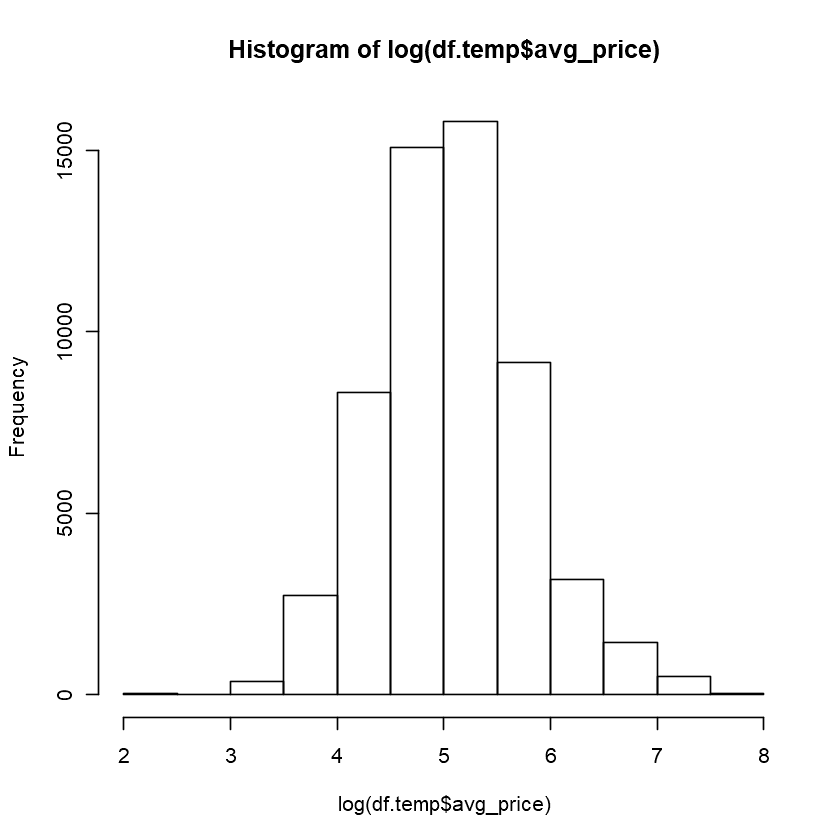

In [12]:
df.temp<-df

df.temp$avg_price[df.temp$avg_price > 2000]<-NA

summary(df.temp$avg_price)

summary(df$avg_price)

hist(log(df.temp$avg_price))

In [13]:
df$avg_price<-log(df.temp$avg_price)

## min_price

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   10.0    97.0   149.0   198.6   229.0  2000.0      97 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0     97.0    149.0    211.1    229.0 111569.0 

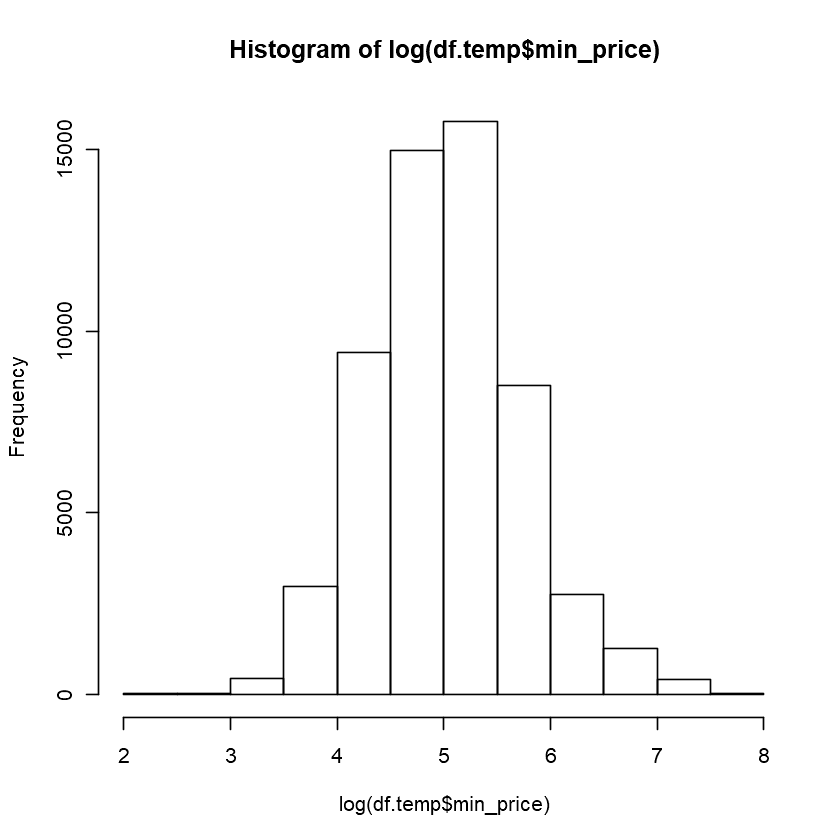

In [14]:
df.temp<-df

df.temp$min_price[df.temp$min_price > 2000]<-NA

summary(df.temp$min_price)

summary(df$min_price)

hist(log(df.temp$min_price))

In [15]:
df$min_price<-log(df.temp$min_price)

## max_price

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   10.0   105.0   160.0   222.2   256.0  2000.0     144 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0    105.0    160.0    238.3    259.0 119917.0 

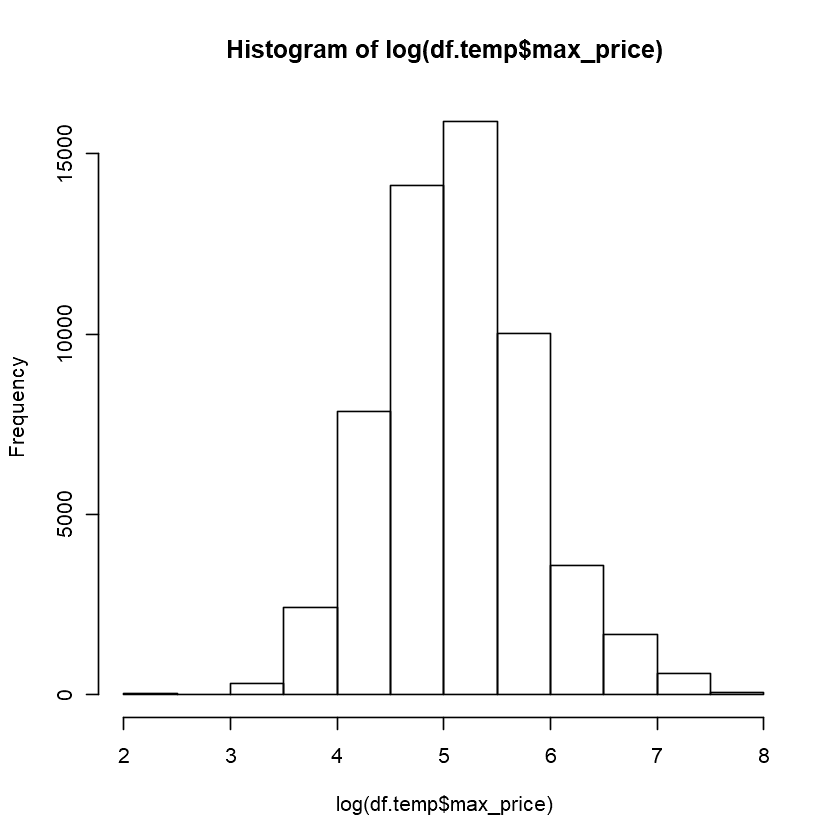

In [16]:
df.temp<-df

df.temp$max_price[df.temp$max_price > 2000]<-NA

summary(df.temp$max_price)

summary(df$max_price)

hist(log(df.temp$max_price))

In [17]:
df$max_price<-log(df$max_price)

## accommodates

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   2.000   3.163   4.000  16.000 


    1     2     3     4     5     6     7     8     9    10    11    12    13 
 4995 26495  4619 11456  2427  3810   634  1117   209   394    82   184     4 
   14    15    16 
   69    46   168 

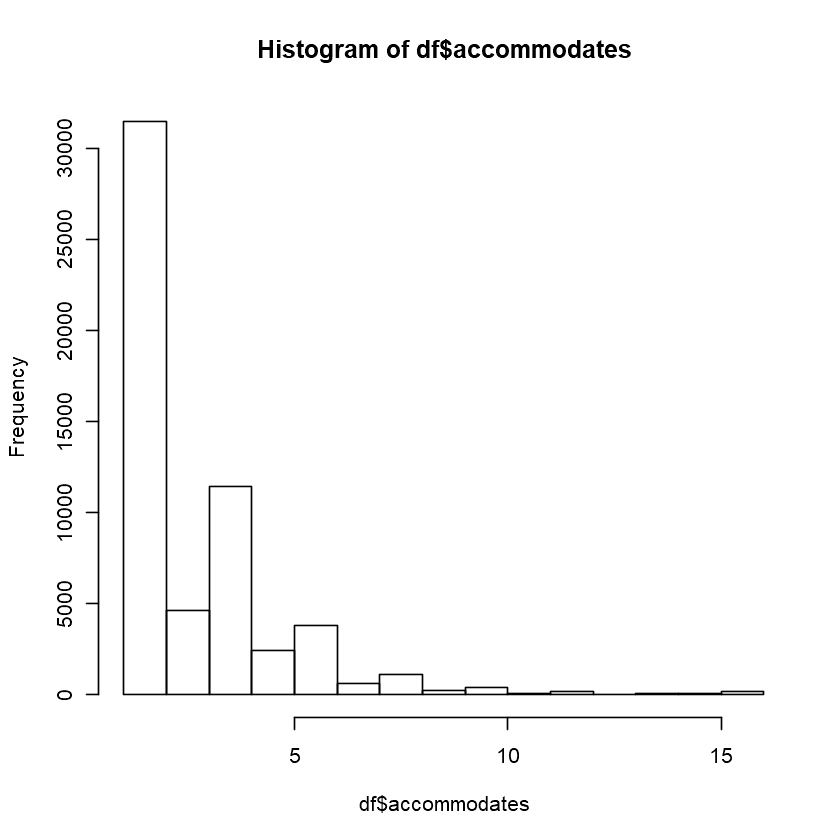

In [18]:
summary(df$accommodates)
hist(df$accommodates)

table(df$accommodates)

In [19]:
#convert into factor
df$accommodates.norm<-cut(df$accommodates, c(1,2,3,4,5,6,10000), labels = c("One", "Two", "Three", "Fore", "Five", "More"), right = FALSE)

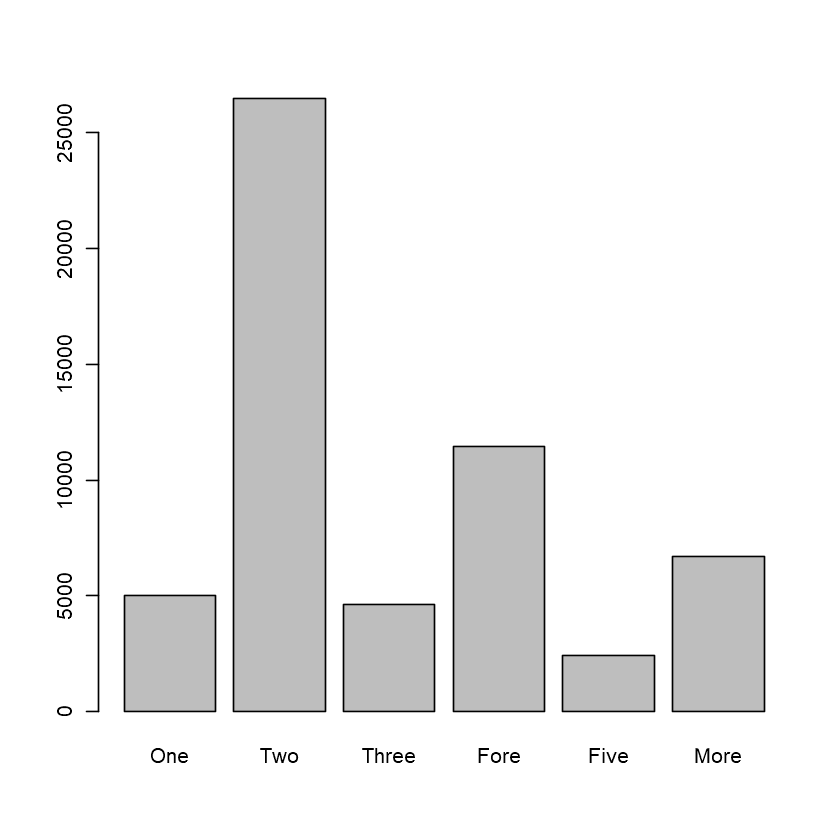

In [20]:
plot(df$accommodates.norm)

## bathrooms

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   1.000   1.376   1.500  15.000     222 


    0   0.5     1   1.5     2   2.5     3   3.5     4   4.5     5   5.5     6 
  656   138 40095  3481  7739  1432  1079   346   454    57   572     5   113 
    7   7.5     8    10    14    15 
   33     1   112   113     5    56 

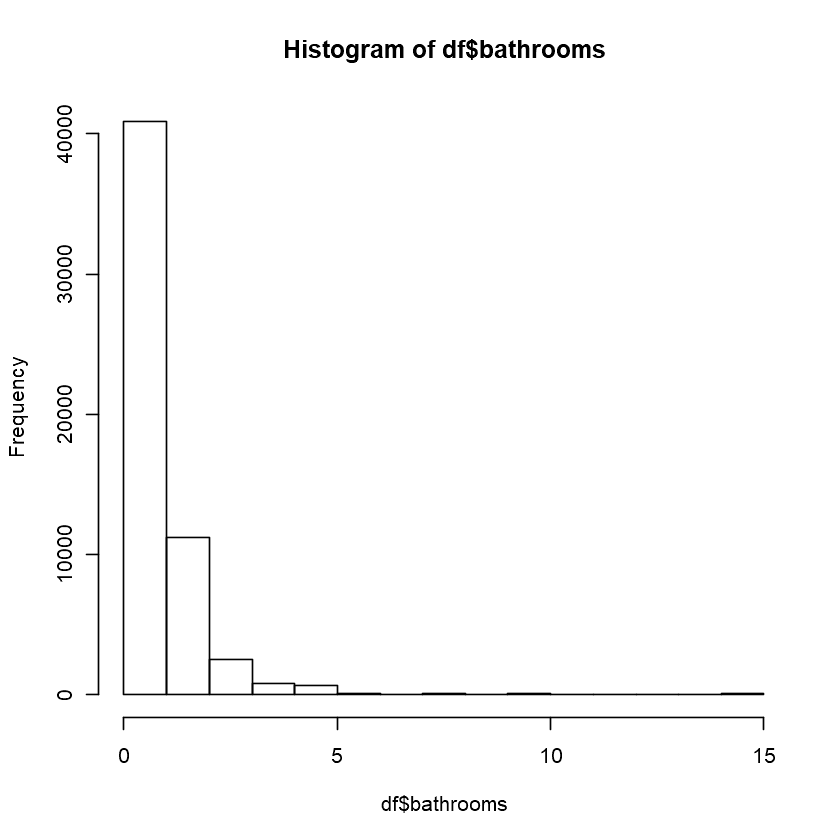

In [21]:
summary(df$bathrooms)
hist(df$bathrooms)

table(df$bathrooms)

In [22]:
#convert into factor
df$bathrooms<-cut(df$bathrooms, c(0,1,2,10000), labels = c("None", "One", "Several"), right = FALSE)


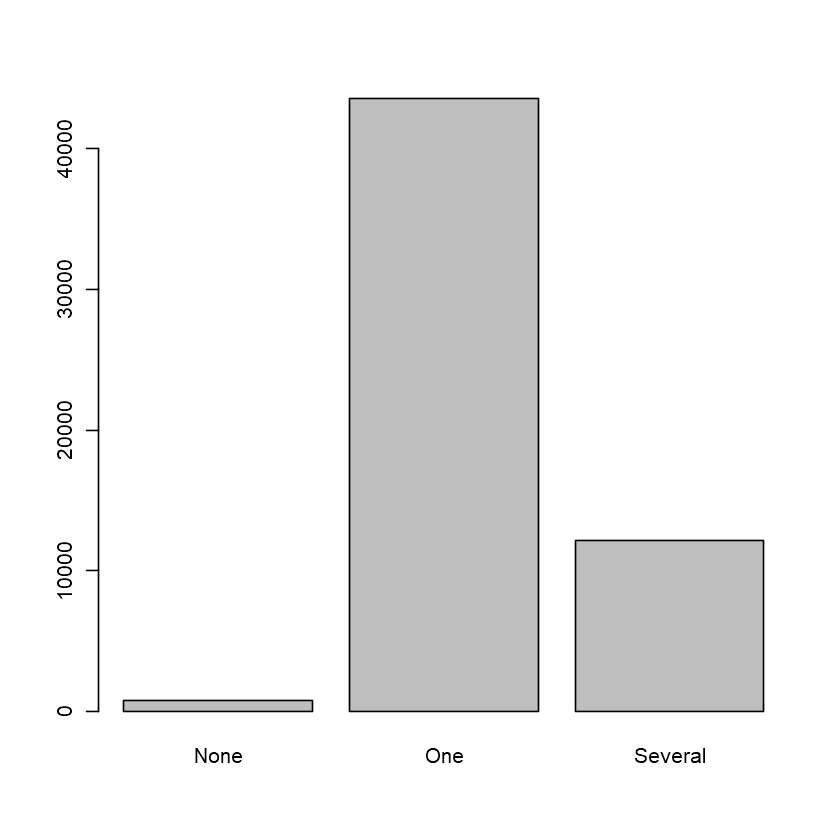

In [23]:
plot(df$bathrooms)

## bedrooms

In [24]:
summary(df$bedrooms)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   1.000   1.308   2.000  15.000       5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   1.000   1.308   2.000  15.000       5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.6931  0.6931  0.7685  1.0986  2.7726       5 

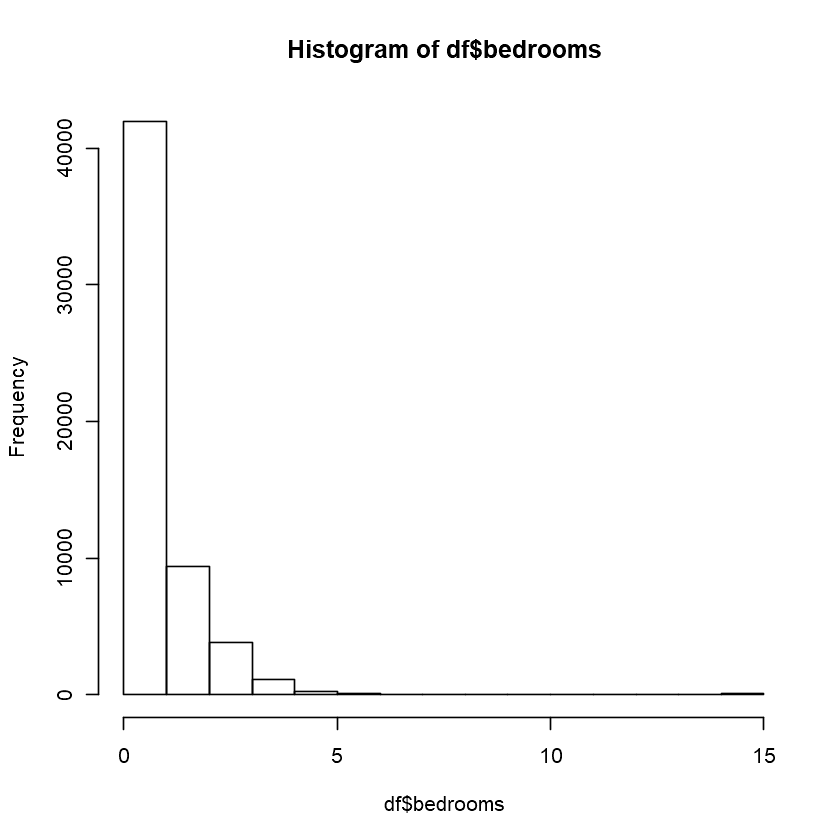

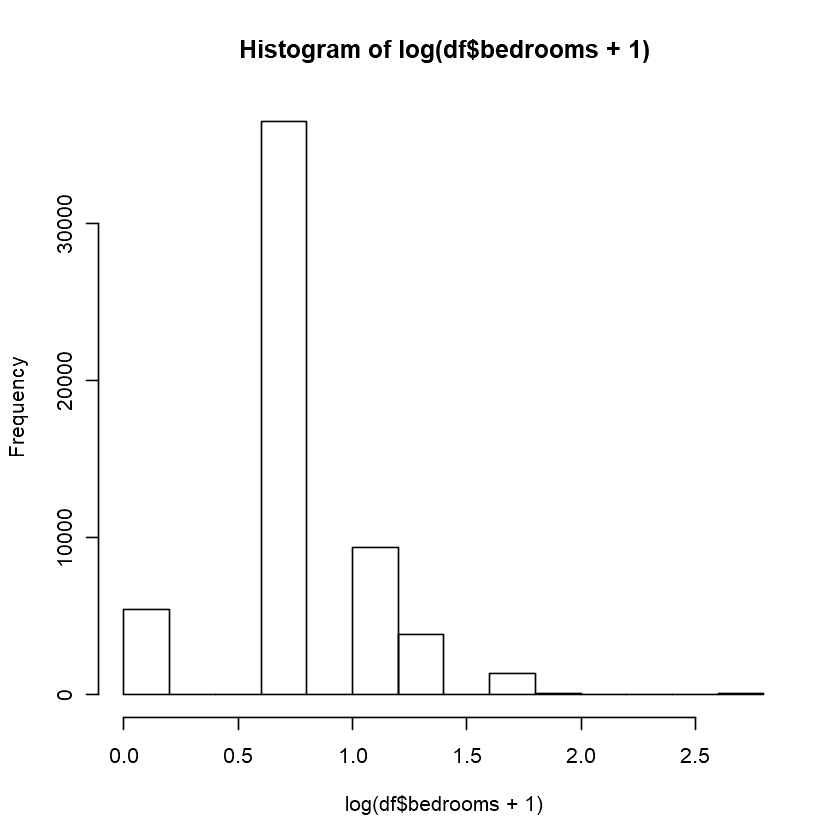

In [25]:
summary(df$bedrooms)
hist(df$bedrooms)


#check the log distribution
summary(log(df$bedrooms + 1))
hist(log(df$bedrooms + 1))

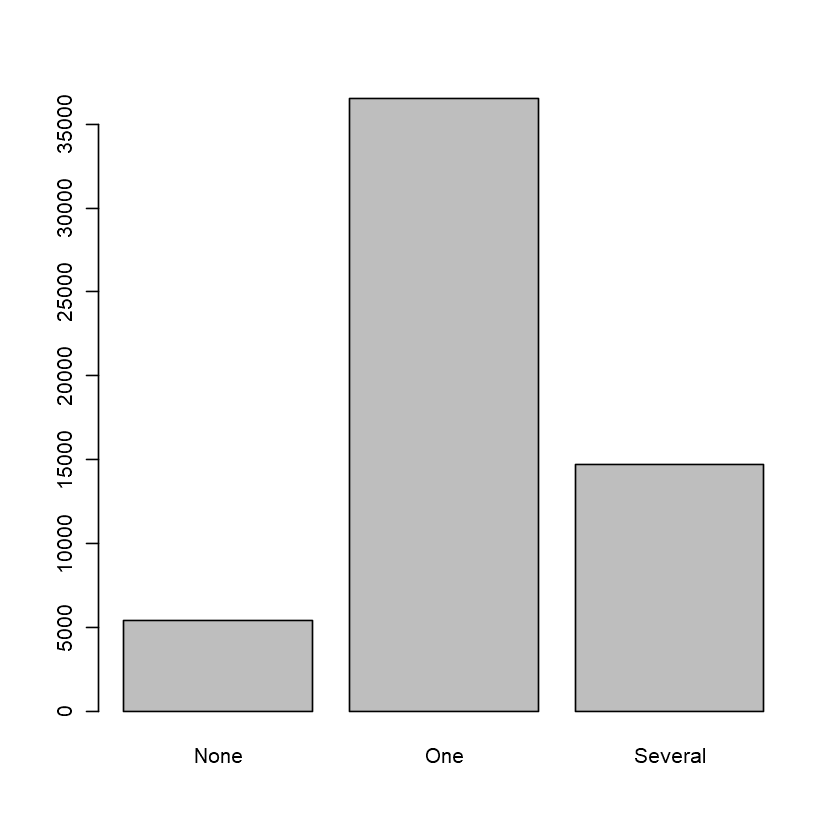

In [26]:
#convert into factor
df$bedrooms<-cut(df$bedrooms, c(0,1,2,10000), labels = c("None", "One", "Several"), right = FALSE)
plot(df$bedrooms)


## beds

In [27]:
summary(df$beds)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.769   2.000  20.000 

### Checking the outliers

In [28]:
df.test<-df[df$beds == 30,]

print(df.test[1,c('property_type', 'beds', 'bedrooms')])

   property_type beds bedrooms
NA          <NA>   NA     <NA>


### Checking the outliers (looks to be a real one, keeping it)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.769   2.000  20.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6931  0.6931  0.6931  0.9488  1.0986  3.0445 

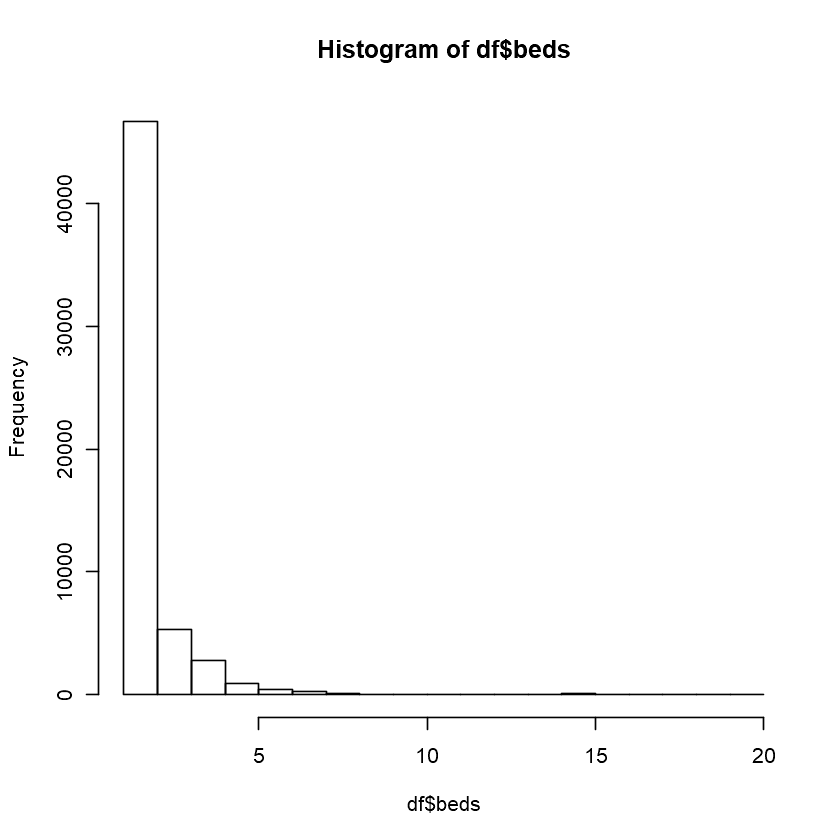

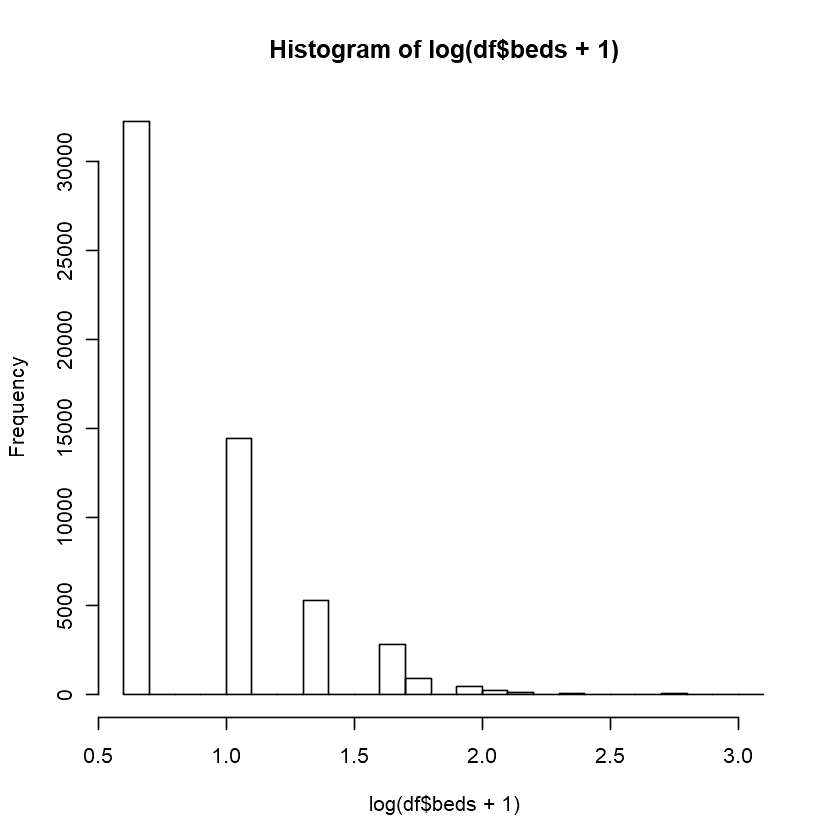

In [29]:
summary(df$beds)
hist(df$beds)


#check the log distribution
summary(log(df$beds + 1))
hist(log(df$beds + 1))

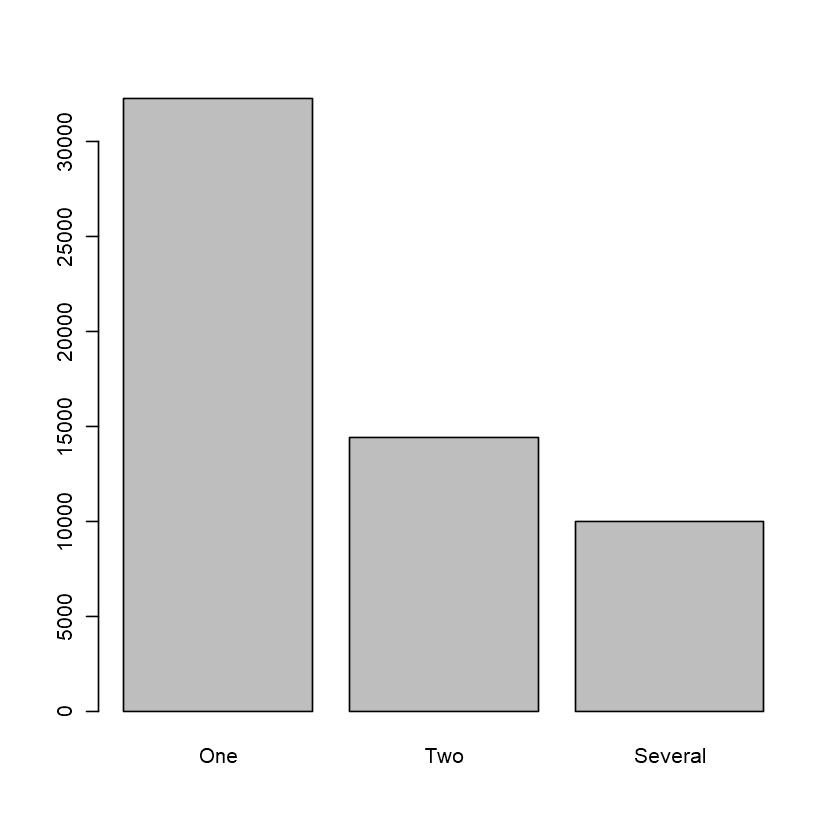

In [30]:
df$beds<-cut(df$beds, c(1,2,3,10000), labels = c("One", "Two", "Several"), right = FALSE)

plot(df$beds)

## security_deposit

In [31]:
summary(df$security_deposit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0   100.0   308.9   500.0  5150.0 

In [32]:
### Checking the outliers

In [33]:
df.test<-df[df$security_deposit > 500,]

print(df.test[c('security_deposit', 'property_type', 'beds', 'bedrooms', 'calculated_host_listings_count')])

      security_deposit      property_type    beds bedrooms
15                1500          Apartment     One     None
18                5000              House Several  Several
19                5000              House Several  Several
20                5000              House Several  Several
26                3000          Apartment     Two  Several
27                3000          Apartment     Two  Several
28                3000          Apartment     Two  Several
32                2000              House Several  Several
34                1000          Townhouse Several  Several
48                1000          Apartment Several  Several
49                1000          Apartment Several  Several
61                 700          Apartment     One      One
62                1500              House     One      One
68                 700          Apartment     One      One
73                5000              House     Two  Several
110               2500              House Several  Sever

### Looks real (keeping the values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0   100.0   308.9   500.0  5150.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   4.615   3.178   6.217   8.547 

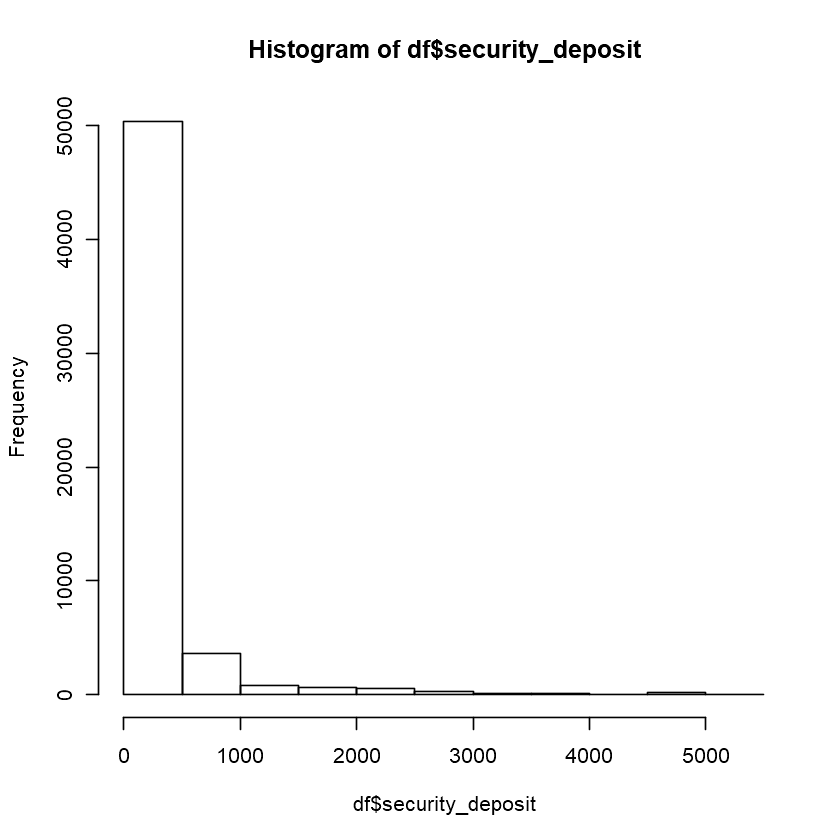

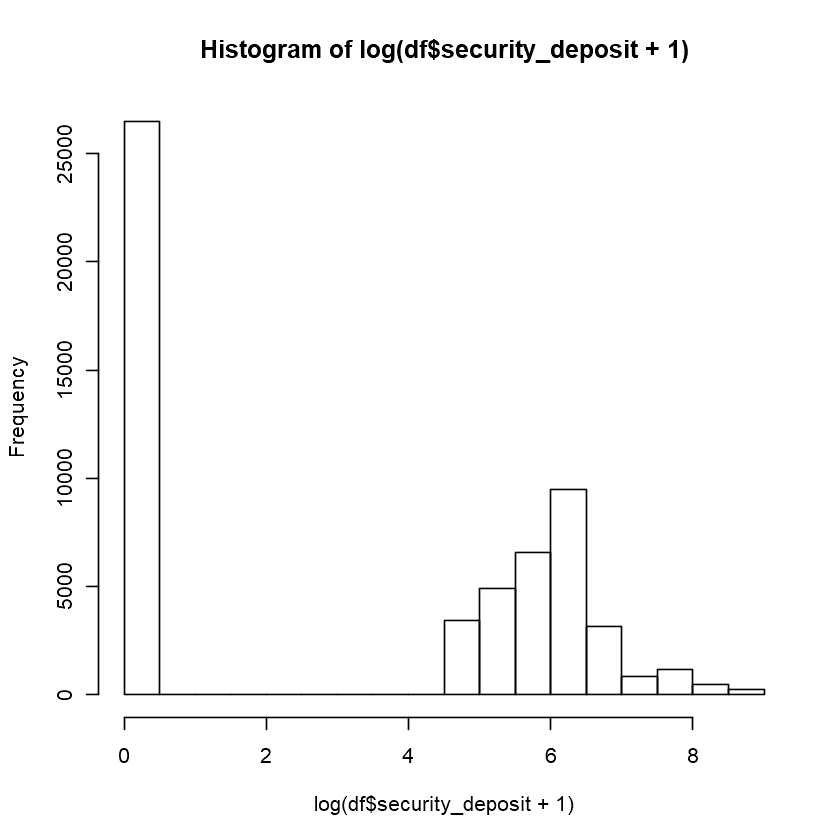

In [34]:
summary(df$security_deposit)
hist(df$security_deposit)


#check the log distribution
summary(log(df$security_deposit + 1))
hist(log(df$security_deposit + 1))

In [35]:
# better convert into factor
df$security_deposit<-cut(df$security_deposit, c(0,1,500,1000, 10000), labels = c("None", "S", "M", "L"), right = FALSE)

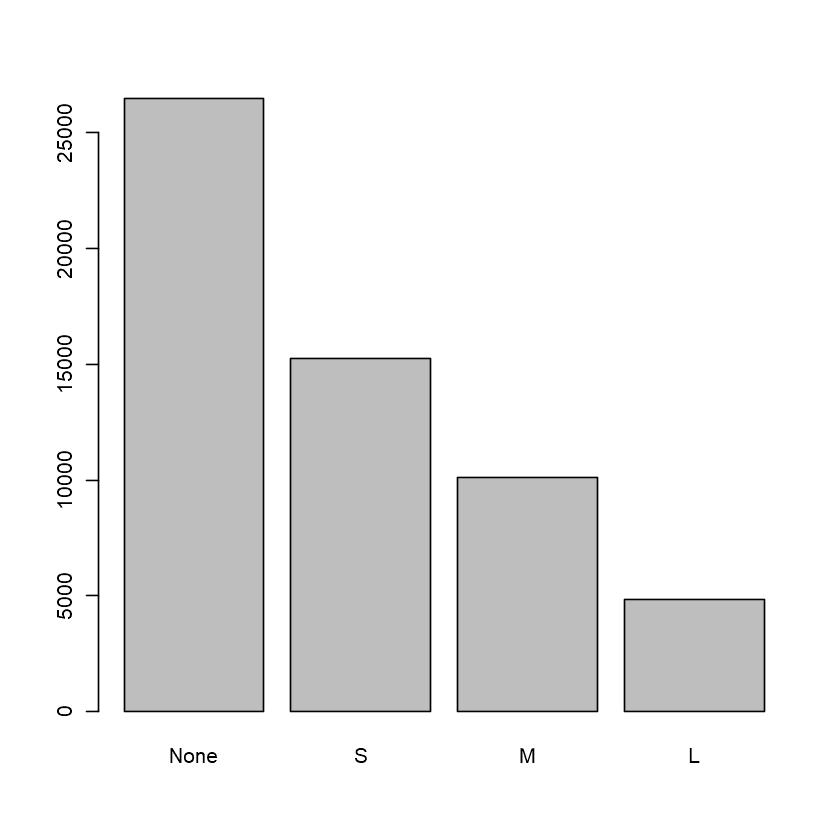

In [36]:
plot(df$security_deposit)

## cleaning_fee

In [37]:
summary(df$cleaning_fee)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    29.0    70.0    84.6   119.0  1500.0 

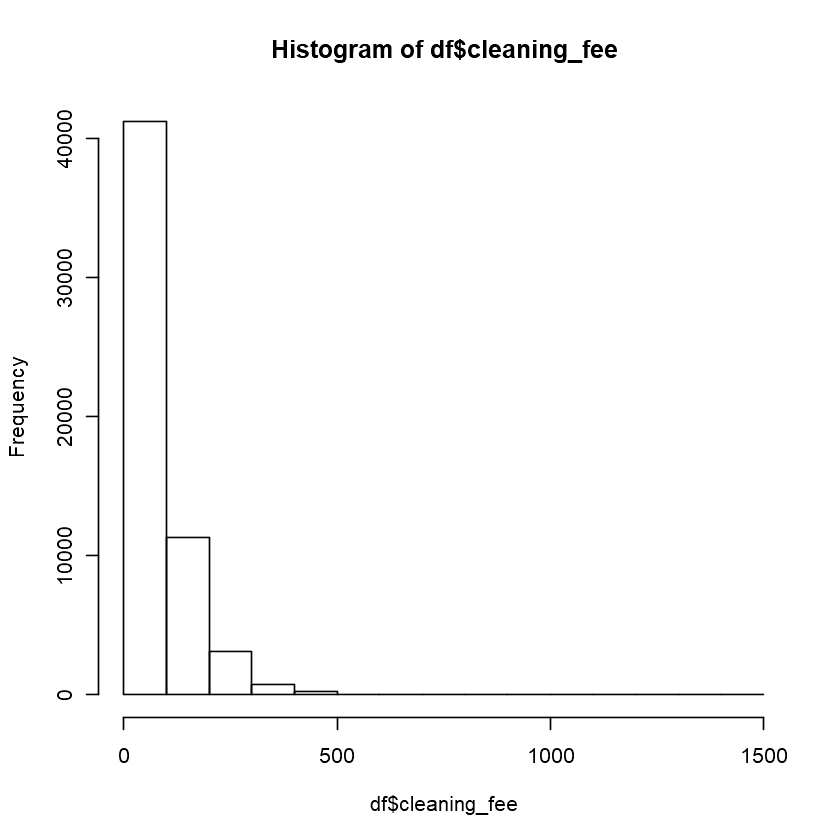

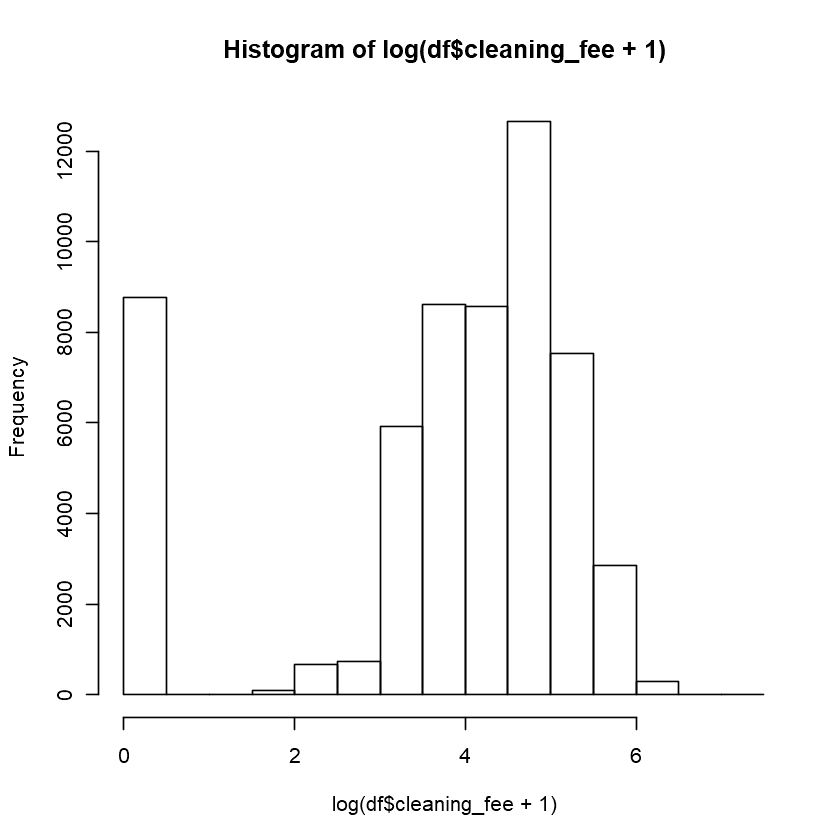

In [38]:
hist(df$cleaning_fee)

hist(log(df$cleaning_fee + 1))

In [39]:
# convertin into factor
df$cleaning_fee<-cut(df$cleaning_fee, c(0,1,50,100, 200, 2000), labels = c("None", "S", "M", "L", "XL"), right = FALSE)

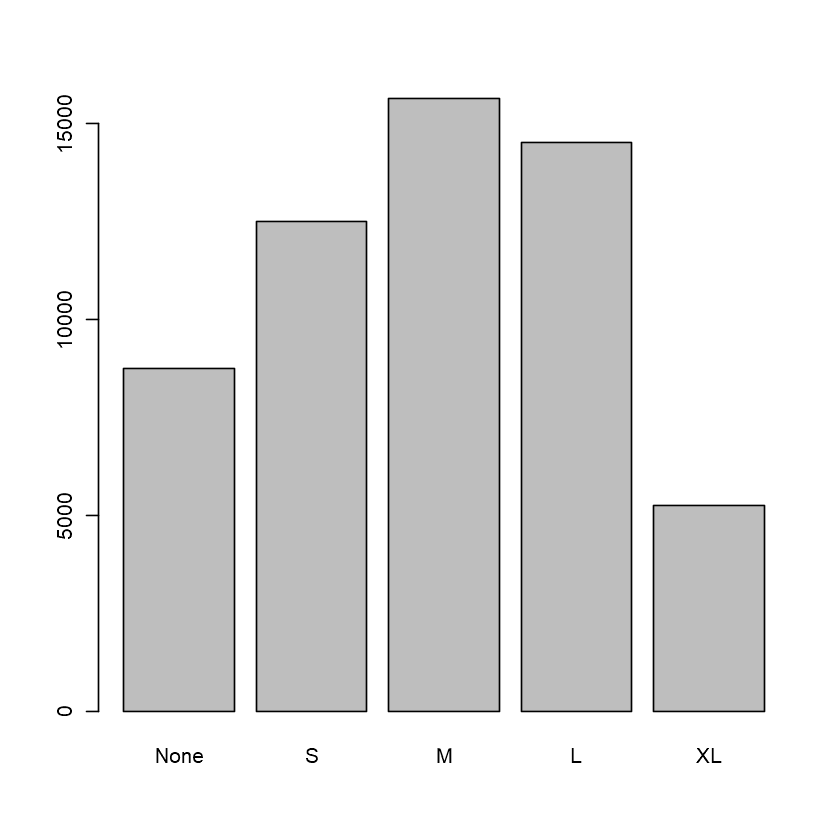

In [40]:
plot(df$cleaning_fee)

## guests_included

In [41]:
summary(df$guests_included)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.711   2.000  30.000 


    0     1     2     3     4     5     6     7     8     9    10    12    15 
  148 35490 13394  1391  4027   604  1103   108   257    49    92    27     2 
   16    30 
   16     1 

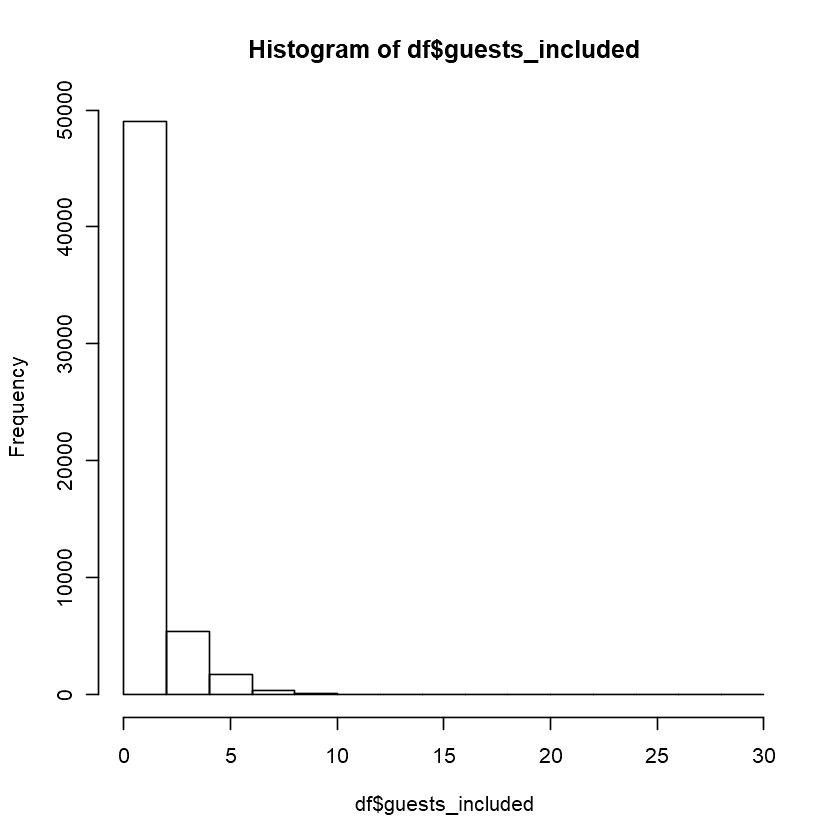

In [42]:
hist(df$guests_included)

table(df$guests_included)

In [43]:
# convertin into factor


df$guests_included<-cut(df$guests_included, c(0,2,3,7, 31), labels = c("upTwo", "upThree", "upSeven", "More"), right = FALSE)

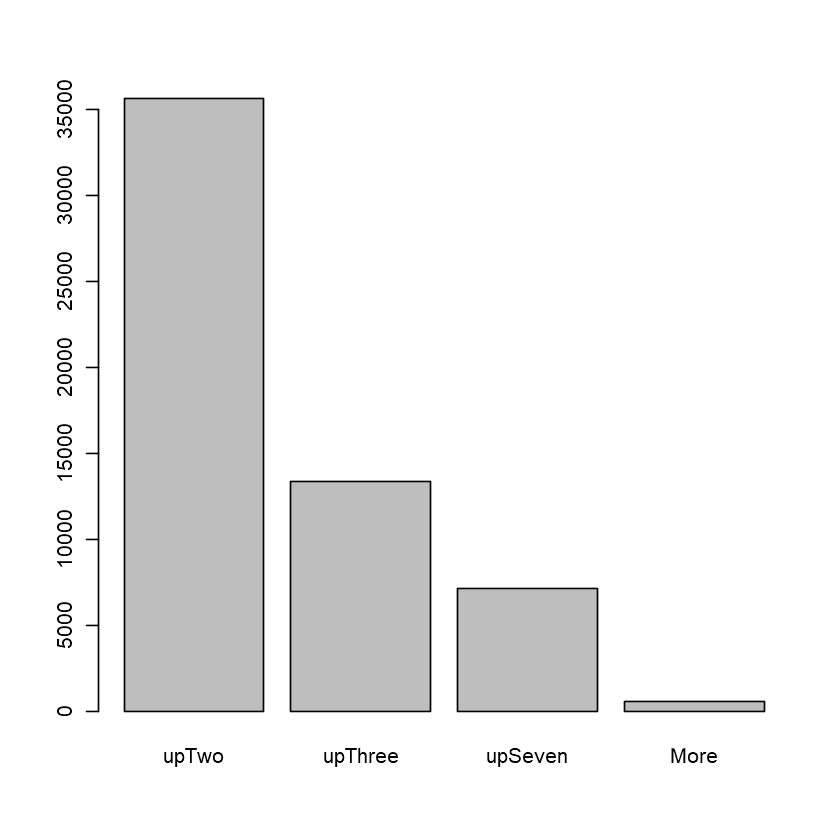

In [44]:
plot(df$guests_included)

## extra_people

In [45]:
summary(df$extra_people)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0    17.2    25.0   300.0 


    0     5     6     7     8     9    10    11    12    13    14    15    16 
28474  2542    13   193   104    18  1825    22   165     9    13  1977    23 
   17    18    19    20    21    22    23    24    25    26    27    28    29 
    5   127   183  3853    12    25     4    18  4873     9    20    15   163 
   30    31    32    33    34    35    36    37    38    39    40    41    42 
 1546    14    50    73    29  1061    22    21    43    76  1168     4    89 
   43    44    45    46    47    48    49    50    51    52    55    56    57 
   10    16   797     7    14    14   109  3677     2    39   141     1     6 
   58    59    60    63    65    68    69    70    71    72    73    75    79 
   13    30   268     1   114     4    25    89     2     2     3   586     8 
   80    85    86    88    89    90    95    99   100   105   110   115   119 
  115    21     1     1     8    47    55   114   915     2     8     6     1 
  120   123   124   125   130   135   140   145   1

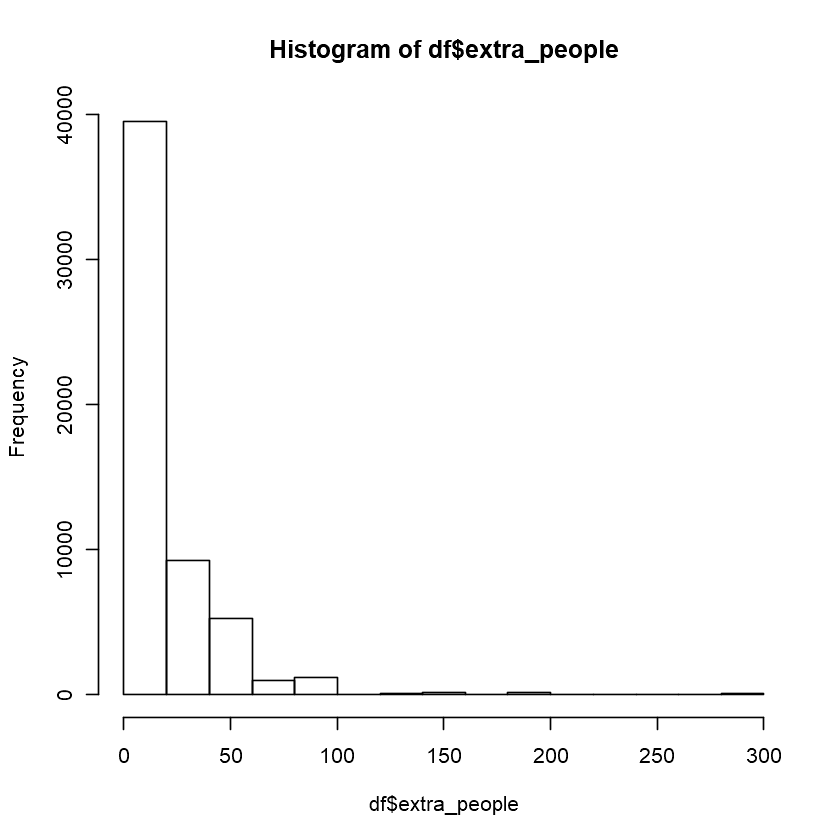

In [46]:
hist(df$extra_people)

table(df$extra_people)

In [47]:
# convertin into factor
df$extra_people<-cut(df$extra_people, c(0,1,50, 100, 400), labels = c("None", "Fifty", "Hundred", "More"), right = FALSE)

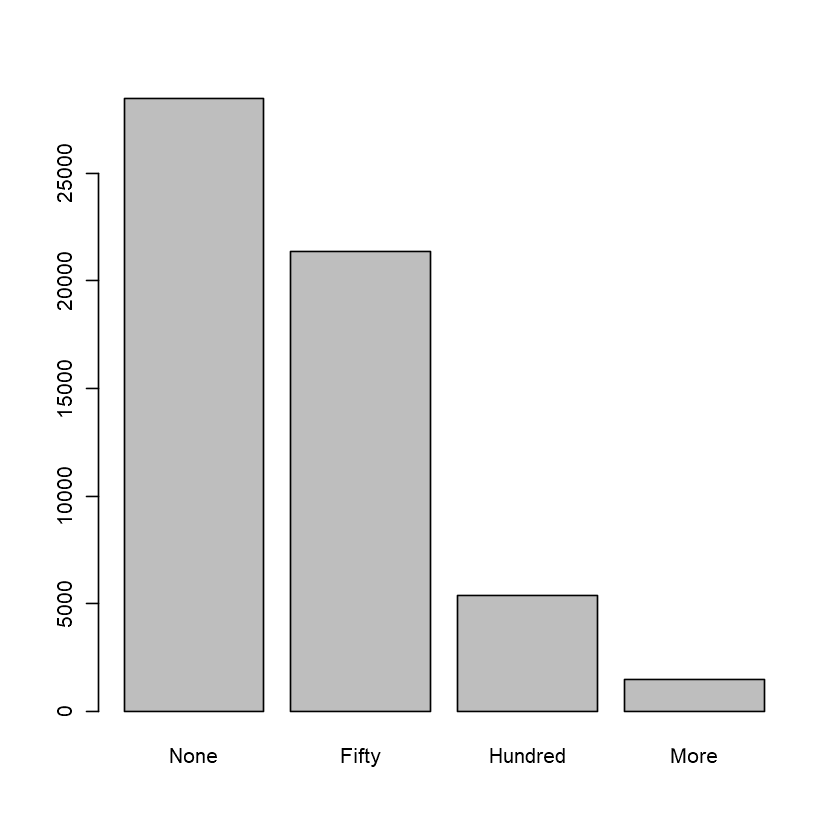

In [48]:
plot(df$extra_people)

## minimum_nights

In [49]:
summary(df$minimum_nights)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00   11.13   30.00  365.00 


    1     2     3     4     5     6     7     8     9    10    11    12    14 
15285 13285  6770  1981  1254   255   649    15    10    56    11     9    84 
   15    16    17    18    19    20    21    22    24    25    27    28    29 
   25     2     5    40     2    18    32     3     6    24     8    35    28 
   30    31    32    33    38    40    42    45    46    50    54    57    58 
15879   351   165     3     1    10     1    12     1     3     1     1     1 
   60    70    80    85    90   110   120   180   182   183   185   190   256 
  143     3     9     1    71     1     7   124     1     2     9     1     1 
  302   360   365 
    1     7     7 

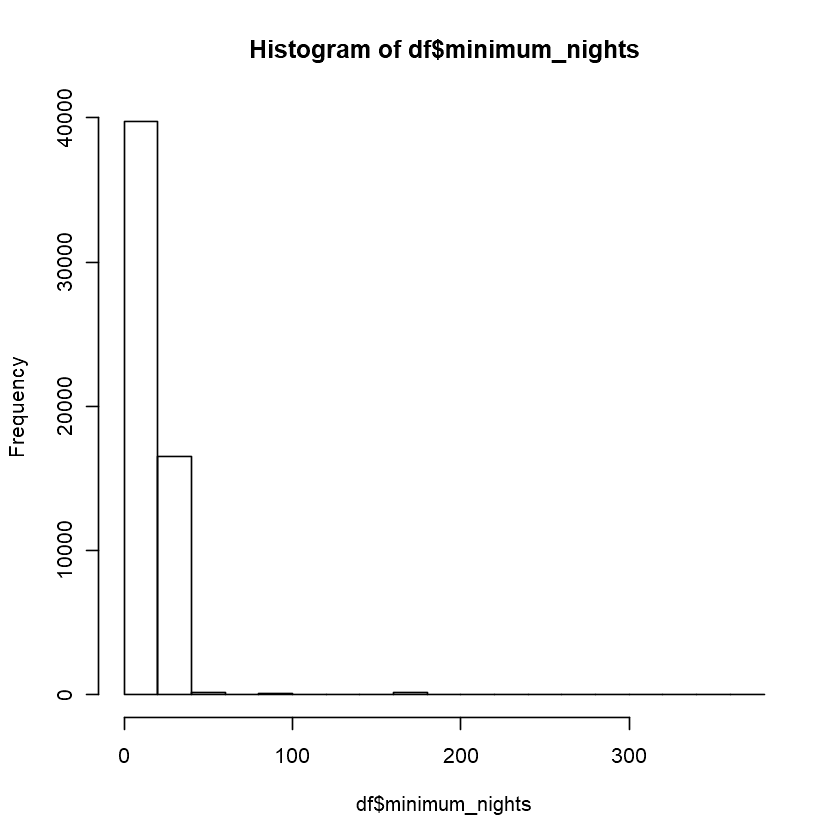

In [50]:
hist(df$minimum_nights)

table(df$minimum_nights)

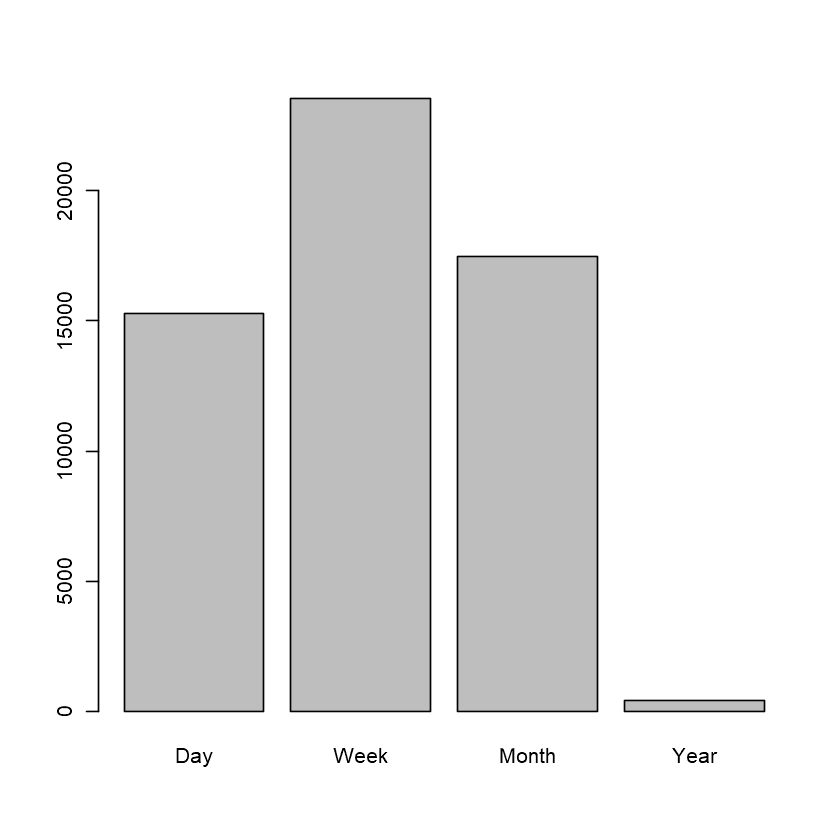

In [51]:
# convertin into factor
df$minimum_nights<-cut(df$minimum_nights, c(1,2,7, 35, 400), labels = c("Day", "Week", "Month", "Year"), right = FALSE)
plot(df$minimum_nights)

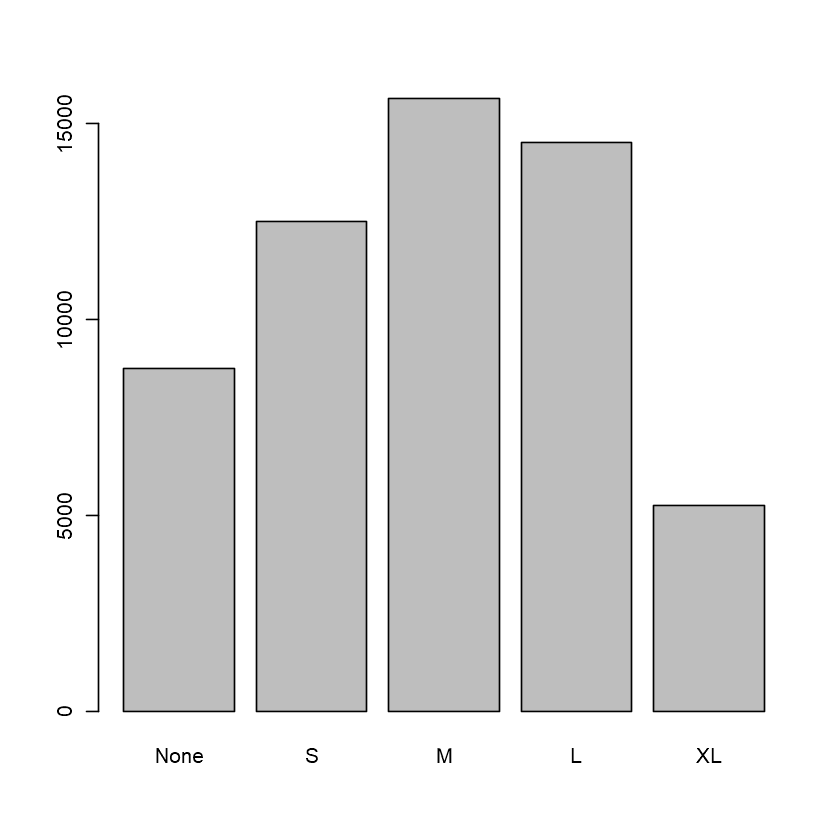

In [52]:
plot(df$cleaning_fee)

## maximum_nights

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.000e+00 2.800e+01 1.820e+02 1.900e+05 1.125e+03 2.147e+09 


        46         56         68         78         84        101        105 
         1          1          1          1          1          1          1 
       115        178        199        256        265        299        301 
         1          1          1          1          1          1          1 
       334        355        390        799        888       1094       1114 
         1          1          1          1          1          1          1 
      1121       5000         36         48         66        107        112 
         1          1          2          2          2          2          2 
       143        181        258        280        352        362        465 
         2          2          2          2          2          2          2 
       760       1080       2000         34         88        102        111 
         2          2          2          3          3          3          3 
       123        302        345       1200         63        1

[1] 56709    50

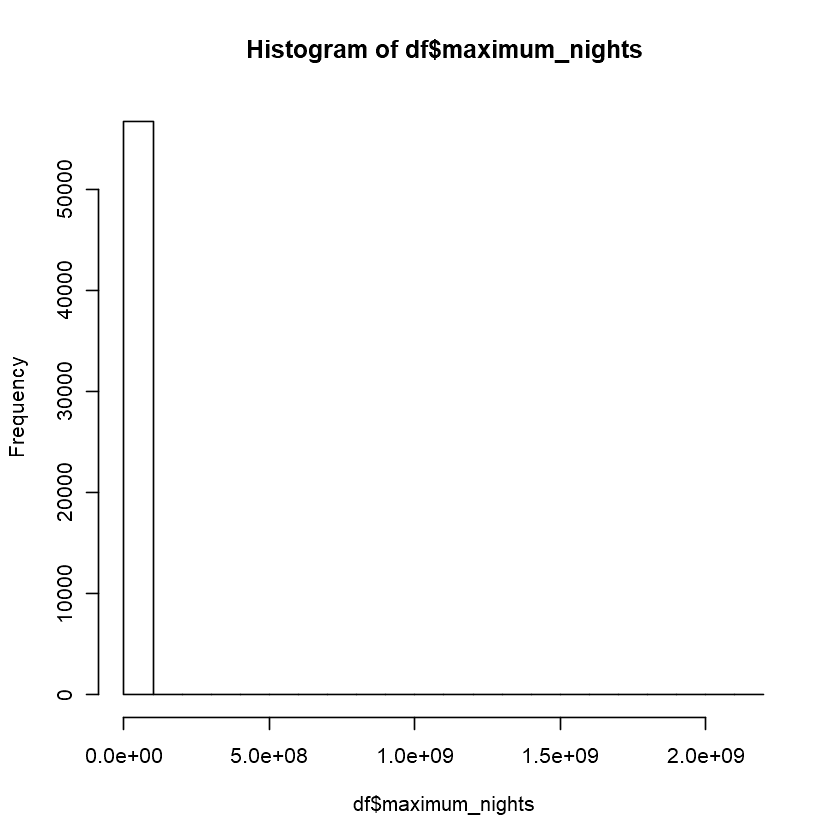

In [53]:
summary(df$maximum_nights)
hist(df$maximum_nights)
sort(table(df$maximum_nights))
dim(df)

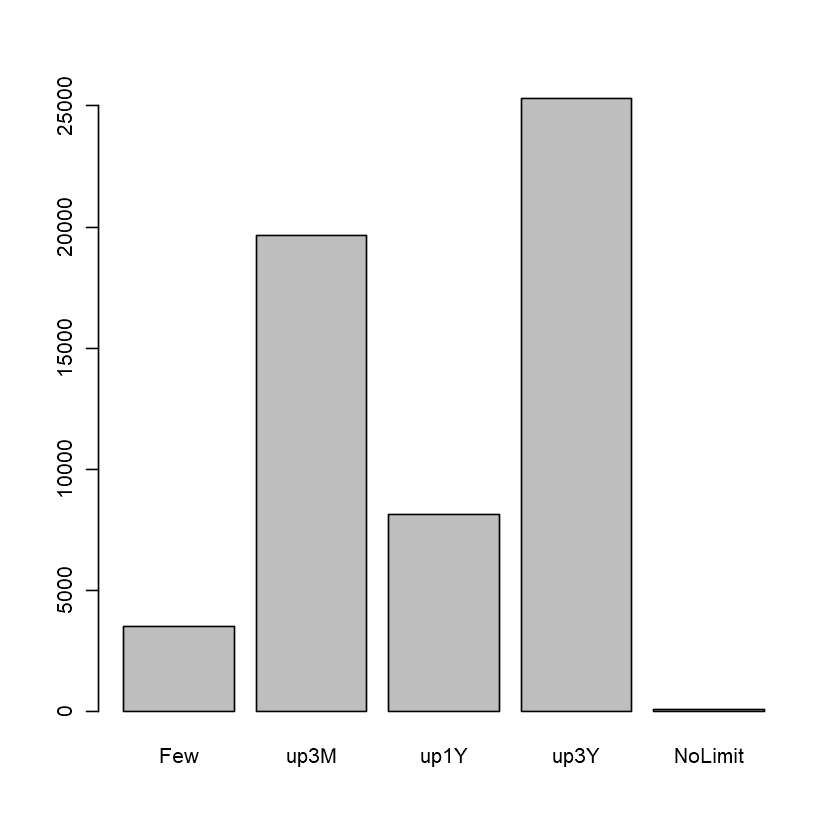

In [54]:
df$maximum_nights<-cut(df$maximum_nights, c(0,10,90,366,1130, 10000), labels = c("Few", "up3M", "up1Y", "up3Y", "NoLimit" ), right = FALSE)

plot(df$maximum_nights)

## number_of_reviews

In [55]:
summary(df$number_of_reviews)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00   13.00   44.57   55.00  771.00 

### Looking into Max value

In [56]:
df[df$number_of_reviews == 771,]

,X,listing_id,week_num,avg_price,min_price,max_price,host_is_superhost,host_identity_verified,neighbourhood_cleansed,zipcode,...,occupied_cat,summary,space,description,neighborhood_overview,notes,transit,host_about,amenities,accommodates.norm
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
18173,90429,545685,51,4.415392,4.234107,4.634729,t,f,Outer Richmond,94121,...,Medium,"New renovated Garden Suite with separated entrance, private Living room, private Bathroom","Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richmond, San Francisco which is close to the Golden Gate Bridge and Golden Gate Park. It is a","New renovated Garden Suite with separated entrance, private Living room, private Bathroom Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richm",,,,We have been living in San Francisco over than10 years. We like the city very much. You will like it too!,"{TV,Wifi,Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,""Lock on bedroom door"",""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation m",Two
18174,90430,545685,1,4.704369,4.488636,4.804021,t,f,Outer Richmond,94121,...,Medium,"New renovated Garden Suite with separated entrance, private Living room, private Bathroom","Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richmond, San Francisco which is close to the Golden Gate Bridge and Golden Gate Park. It is a","New renovated Garden Suite with separated entrance, private Living room, private Bathroom Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richm",,,,We have been living in San Francisco over than10 years. We like the city very much. You will like it too!,"{TV,Wifi,Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,""Lock on bedroom door"",""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation m",Two


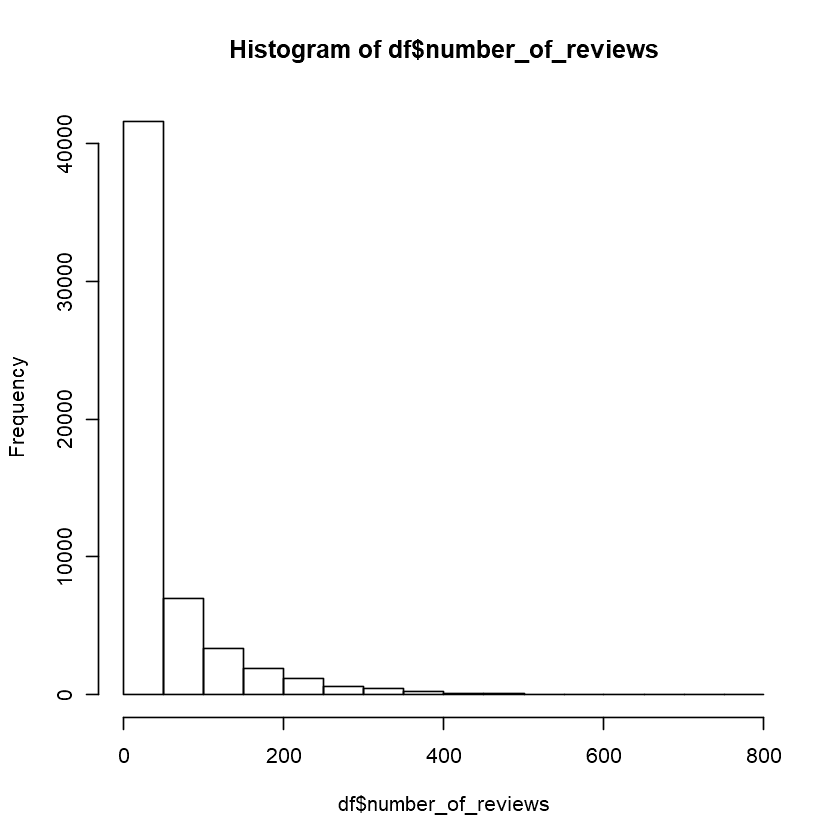

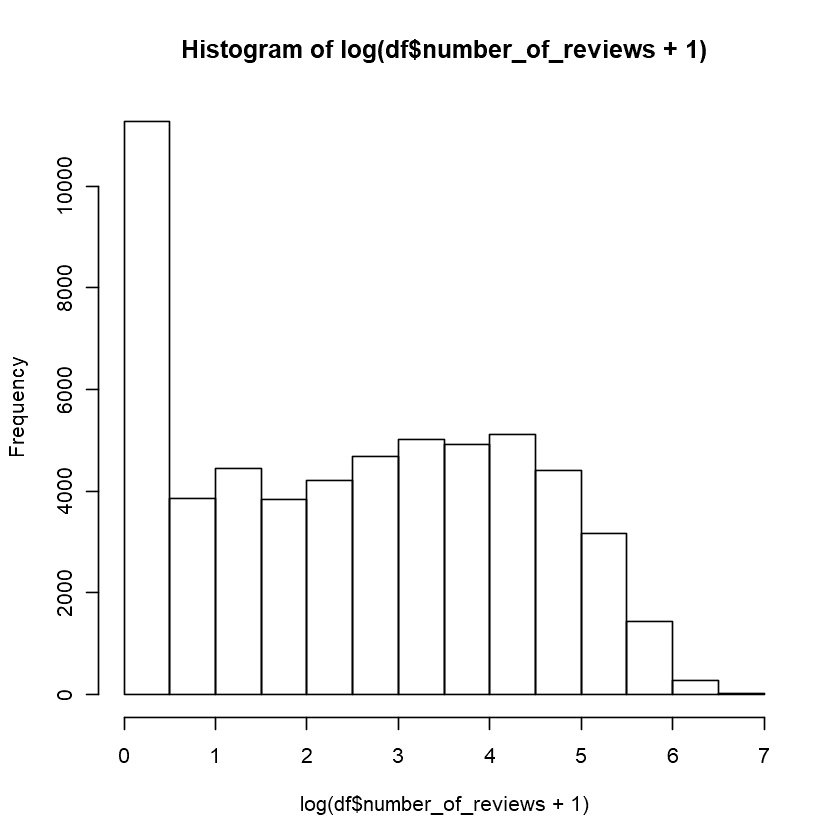

In [57]:
hist(df$number_of_reviews)

hist(log(df$number_of_reviews + 1))

In [58]:
# convertin into factor

df$number_of_reviews<-cut(df$number_of_reviews, c(0,1,50, 150, 1000), labels = c("None", "S", "M", "L"), right = FALSE)

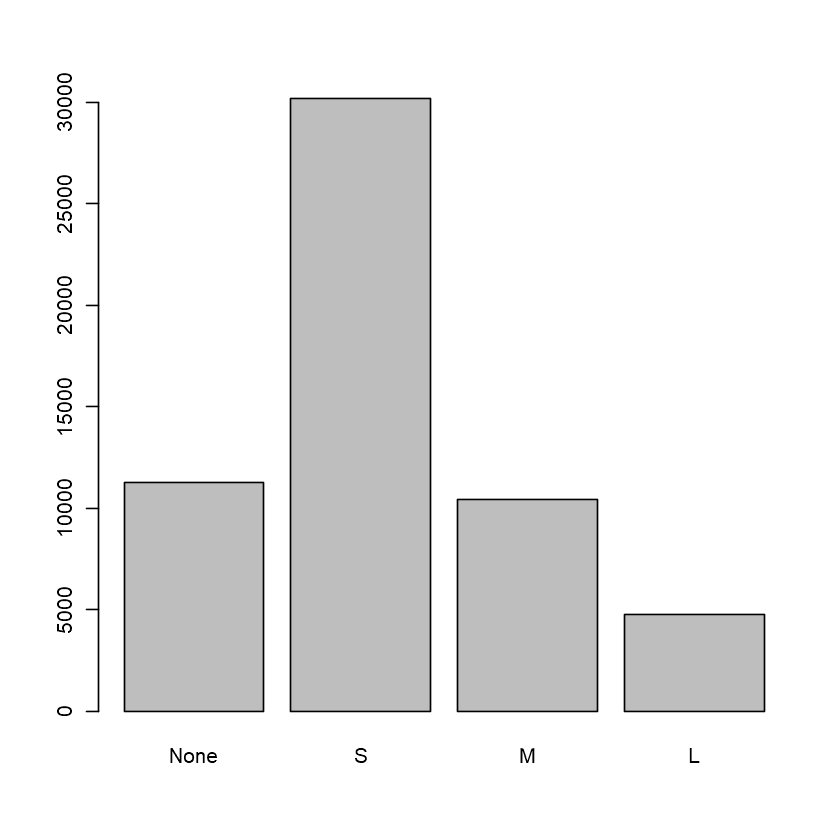

In [59]:
plot(df$number_of_reviews)

## review_scores_accuracy

In [60]:
summary(df$review_scores_accuracy)
dim(df)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    2.0    10.0    10.0     9.7    10.0    10.0   11501 

[1] 56709    50

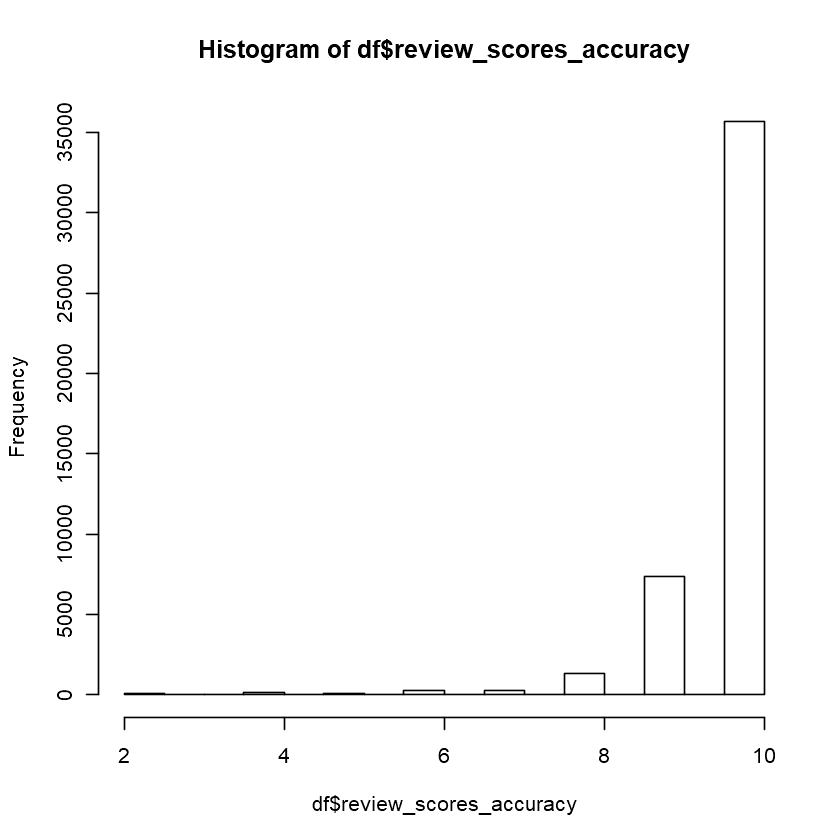

In [61]:
hist(df$review_scores_accuracy)

In [62]:
# replace missing values by 11
df$review_scores_accuracy[is.na(df$review_scores_accuracy)] <- 11

# create a factors
df$review_scores_accuracy<-cut(df$review_scores_accuracy, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

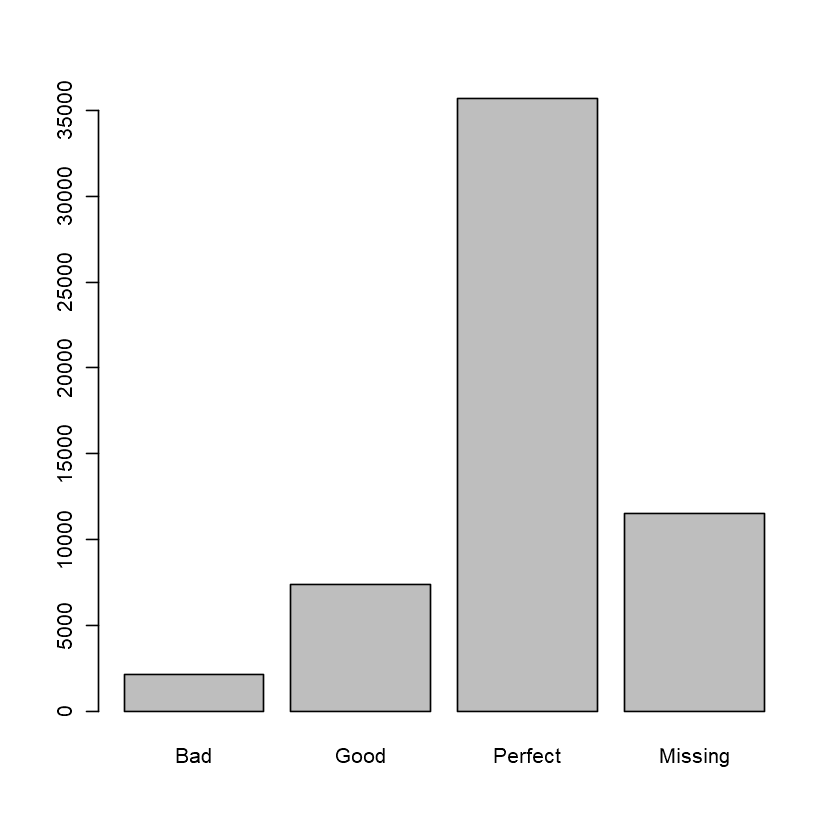

In [63]:
plot(df$review_scores_accuracy)

## review_scores_cleanliness

In [64]:
summary(df$review_scores_cleanliness)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.00    9.00   10.00    9.57   10.00   10.00   11501 

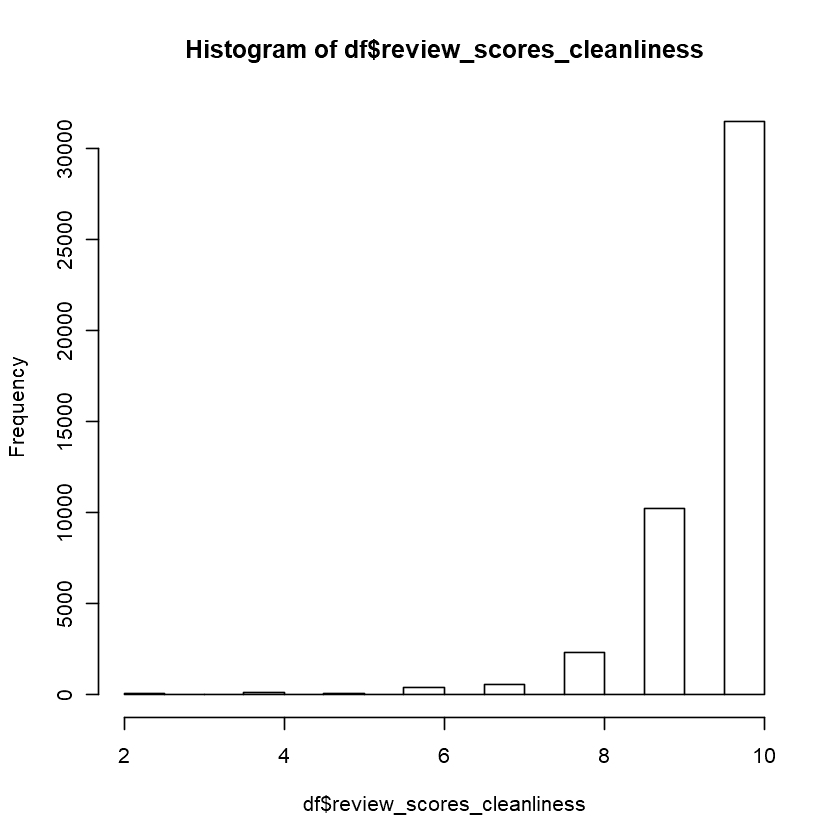

In [65]:
hist(df$review_scores_cleanliness)

In [66]:
# replace missing values by 11
df$review_scores_cleanliness[is.na(df$review_scores_cleanliness)] <- 11

# create a factors
df$review_scores_cleanliness<-cut(df$review_scores_cleanliness, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

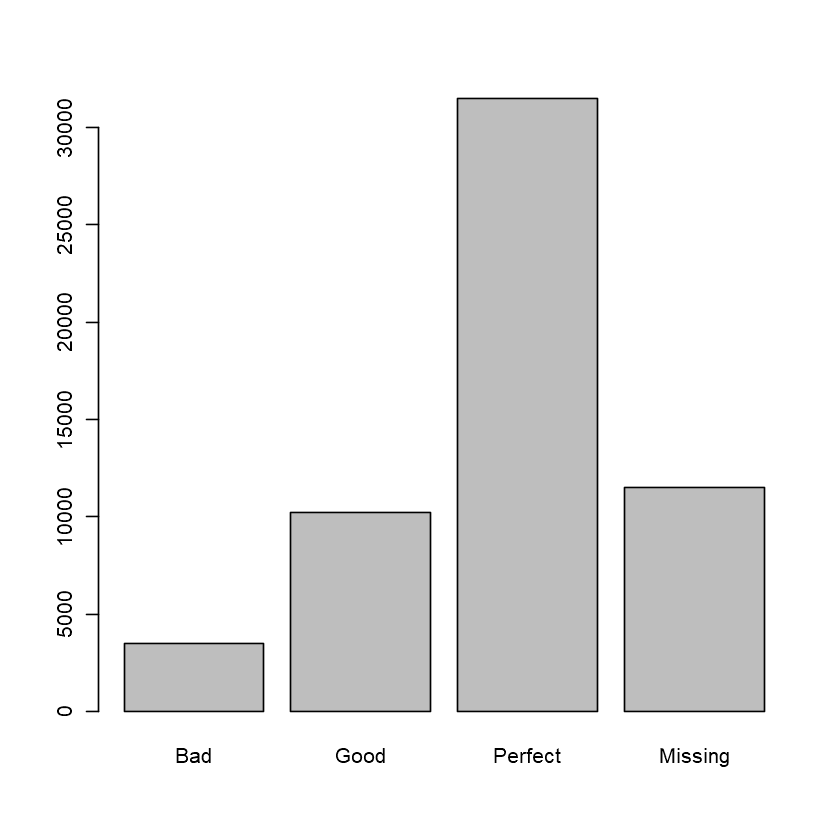

In [67]:
plot(df$review_scores_cleanliness)

## review_scores_checkin

In [68]:
summary(df$review_scores_checkin)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  2.000  10.000  10.000   9.816  10.000  10.000   11517 

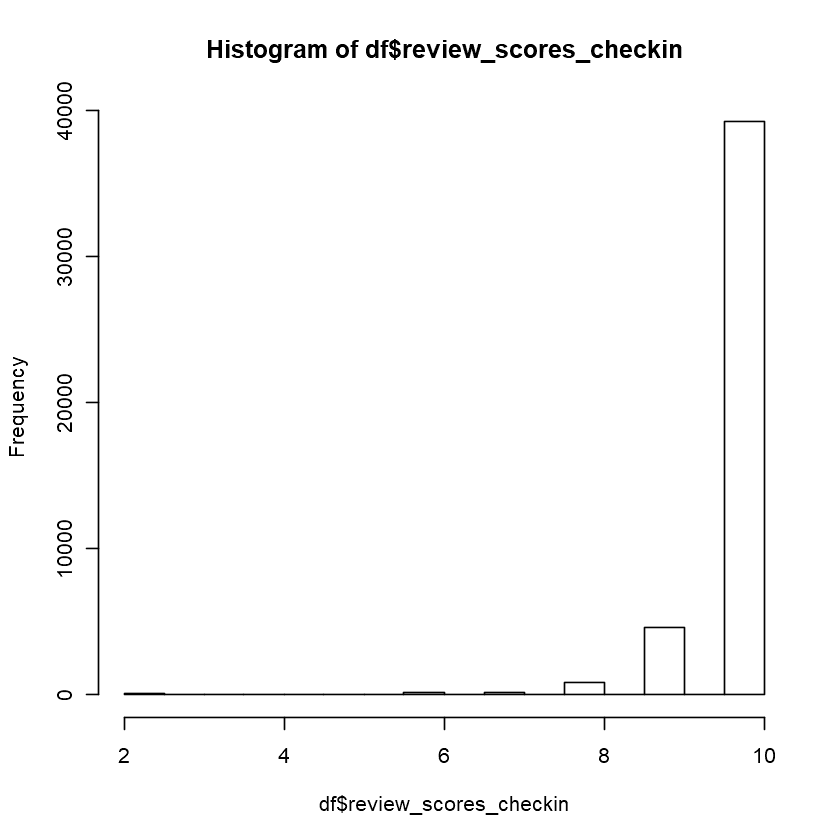

In [69]:
hist(df$review_scores_checkin)

In [70]:
# replace missing values by 11
df$review_scores_checkin[is.na(df$review_scores_checkin)] <- 11

# create a factors
df$review_scores_checkin<-cut(df$review_scores_checkin, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

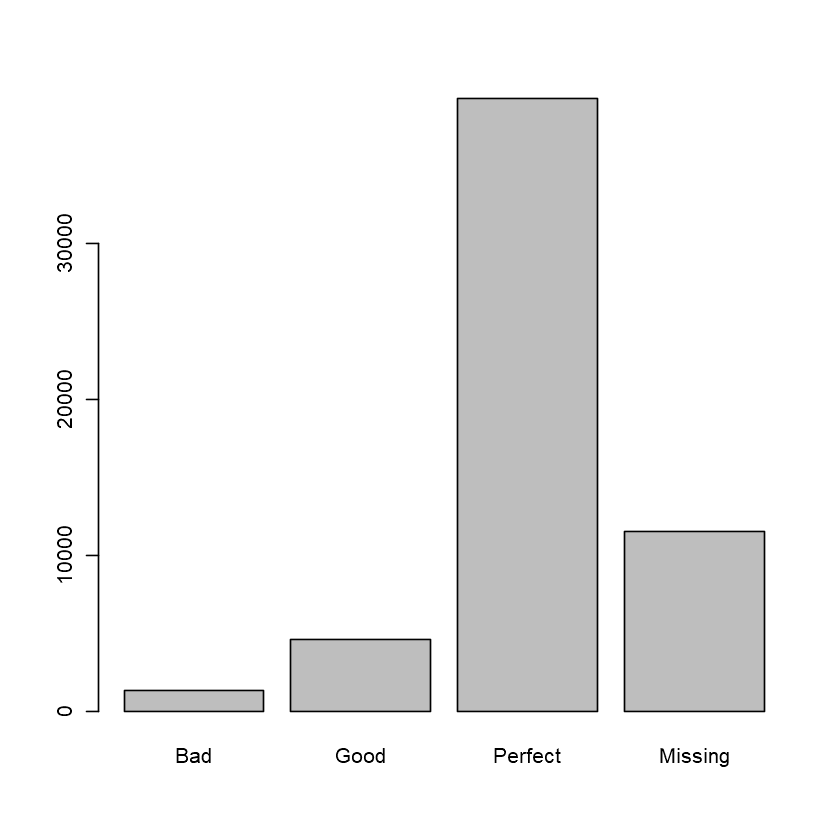

In [71]:
plot(df$review_scores_checkin)

## review_scores_communication

In [72]:
summary(df$review_scores_communication)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  2.000  10.000  10.000   9.792  10.000  10.000   11503 

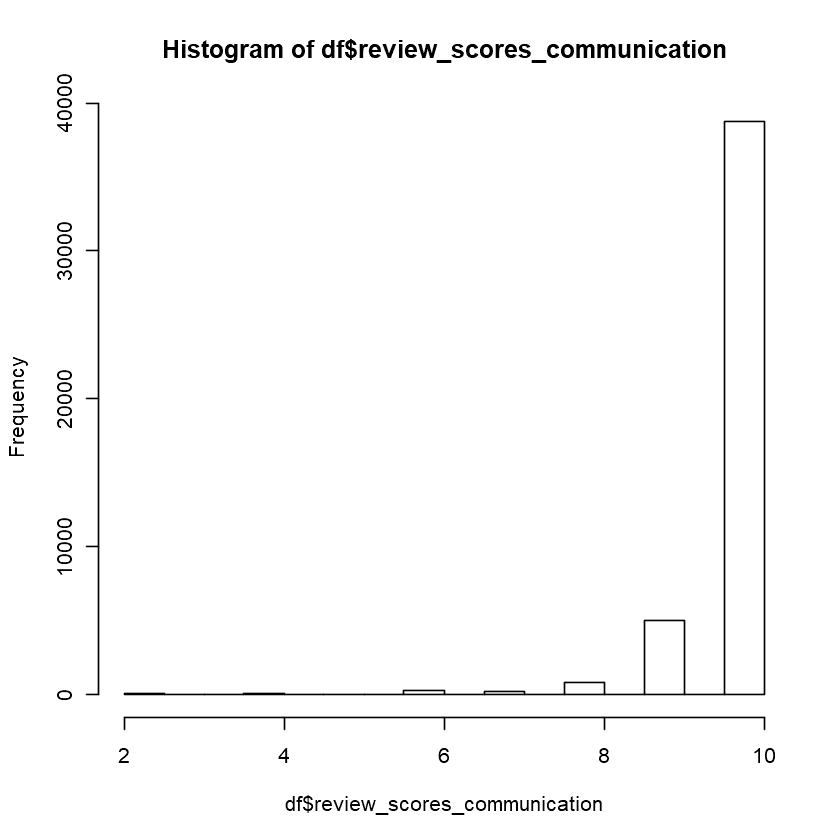

In [73]:
hist(df$review_scores_communication)

In [74]:
# replace missing values by 11
df$review_scores_communication[is.na(df$review_scores_communication)] <- 11

# create a factors
df$review_scores_communication<-cut(df$review_scores_communication, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

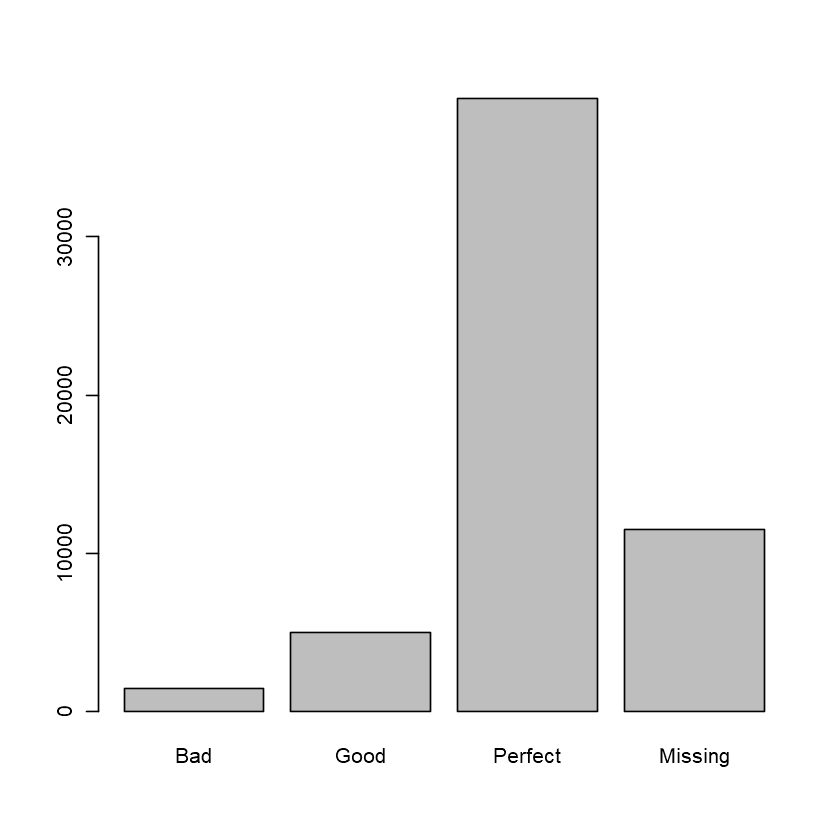

In [75]:
plot(df$review_scores_communication)

## review_scores_location

In [76]:
summary(df$review_scores_location)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  2.000   9.000  10.000   9.629  10.000  10.000   11520 

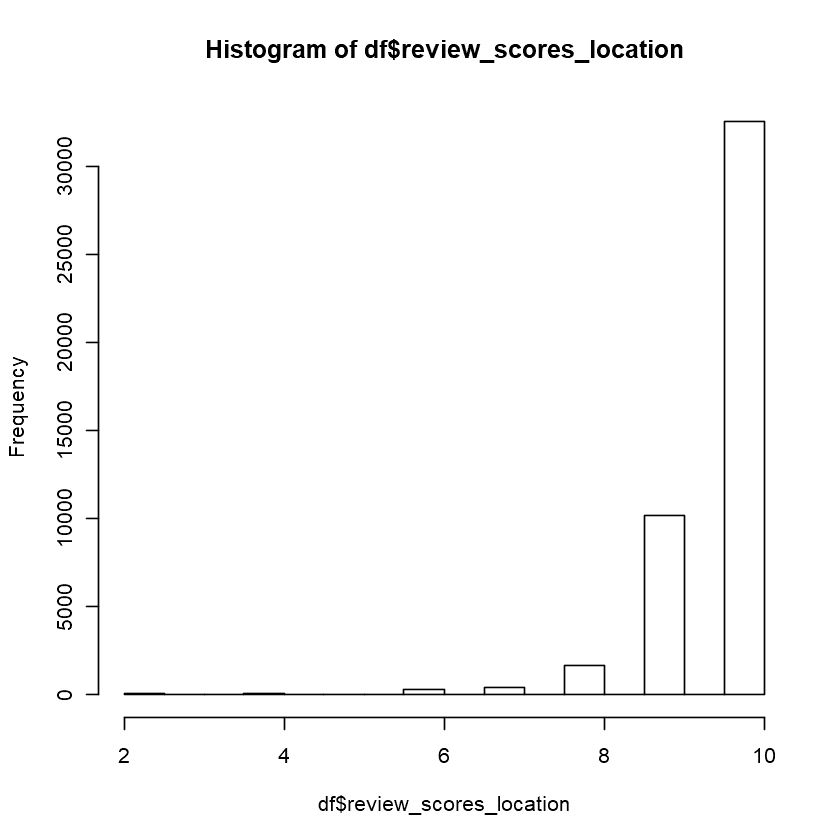

In [77]:
hist(df$review_scores_location)

In [78]:
# replace missing values by 11
df$review_scores_location[is.na(df$review_scores_location)] <- 11

# create a factors
df$review_scores_location<-cut(df$review_scores_location, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

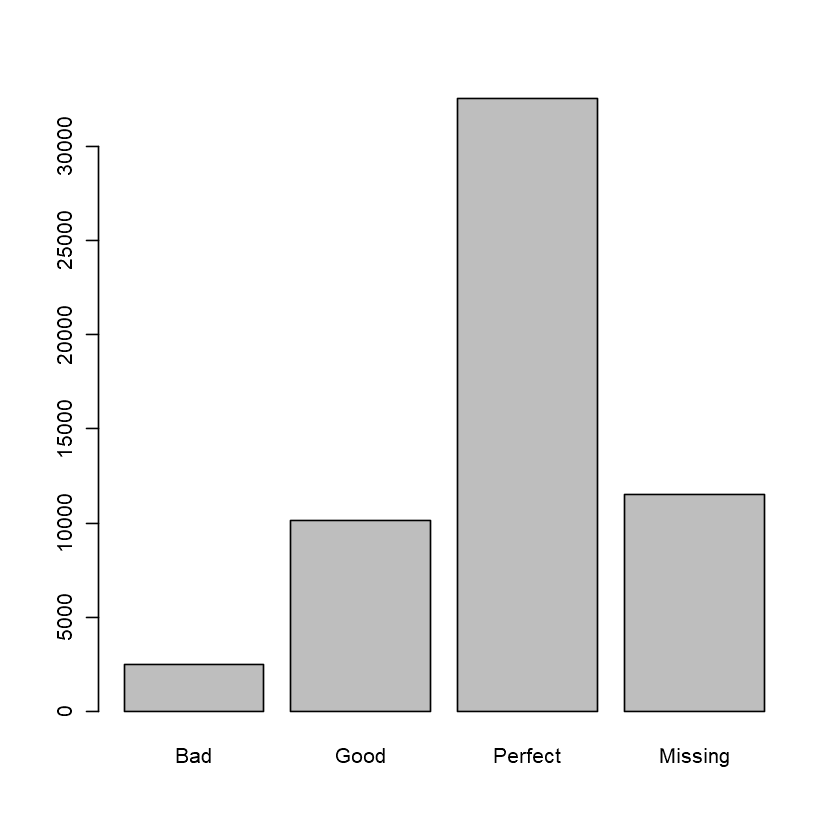

In [79]:
plot(df$review_scores_location)

## review_scores_value

In [80]:
summary(df$review_scores_value)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  2.000   9.000   9.000   9.339  10.000  10.000   11522 

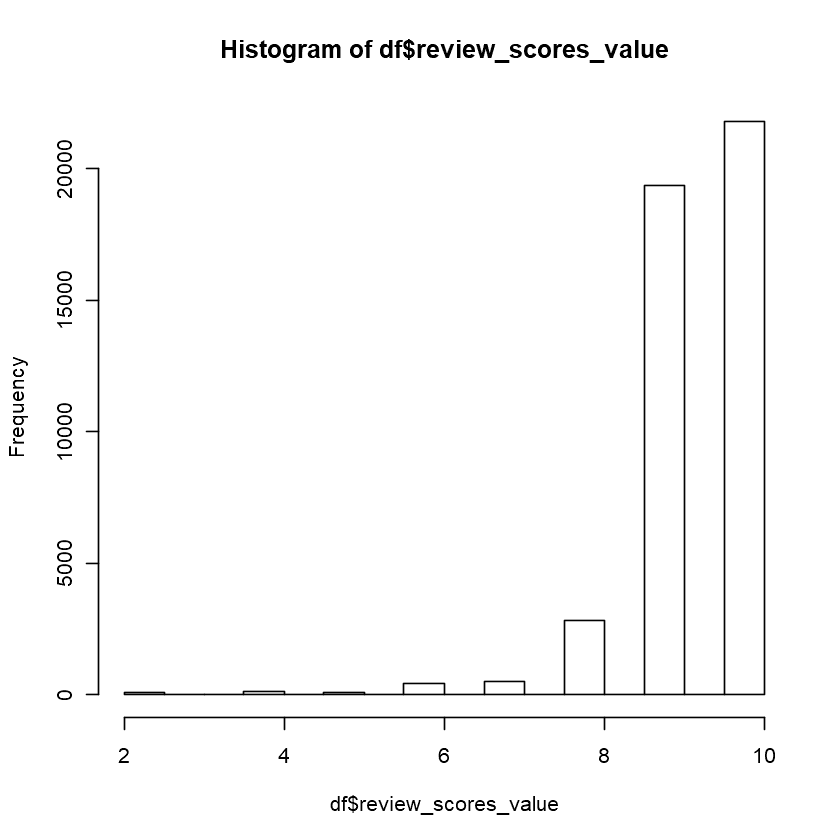

In [81]:
hist(df$review_scores_value)

In [82]:
# replace missing values by 11
df$review_scores_value[is.na(df$review_scores_value)] <- 11

# create a factors
df$review_scores_value<-cut(df$review_scores_value, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

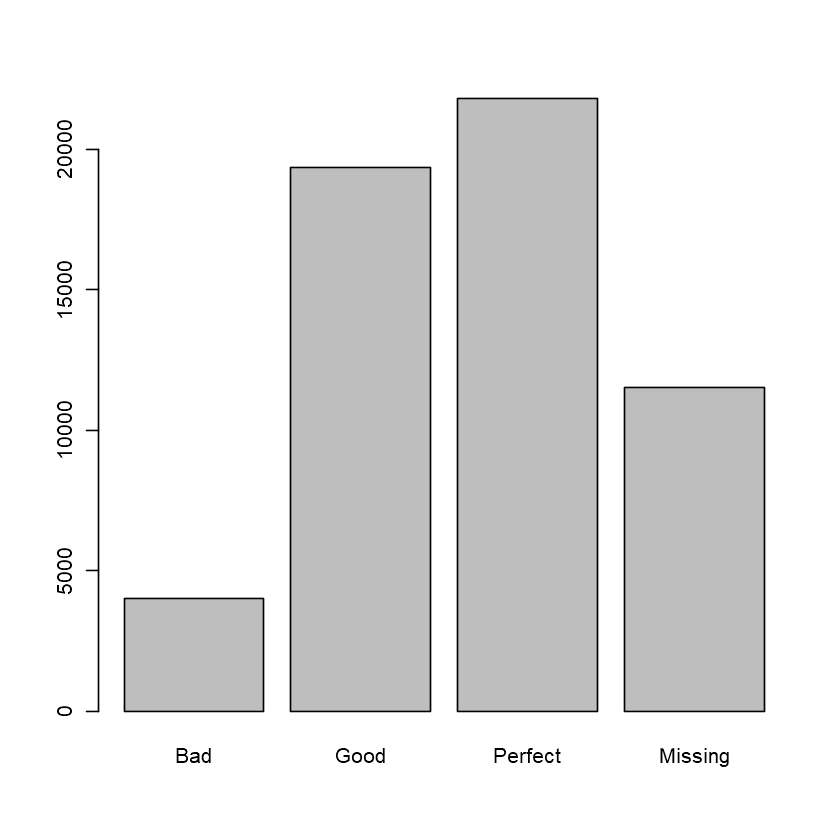

In [83]:
plot(df$review_scores_value)

## calculated_host_listings_count

In [84]:
summary(df$calculated_host_listings_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     1.0     2.0    20.6    11.0   257.0 

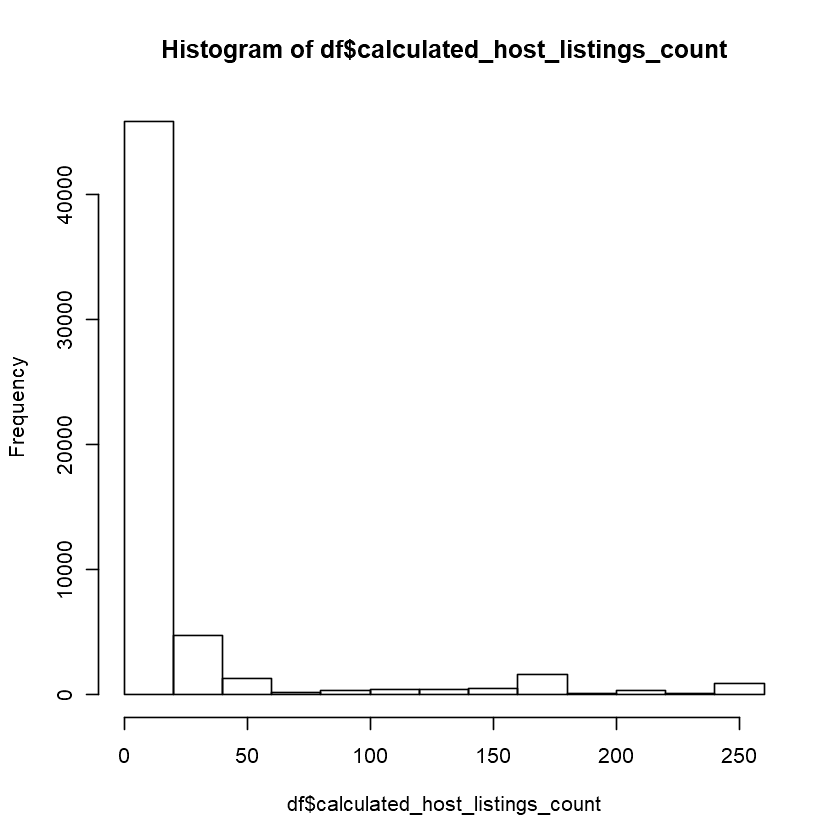

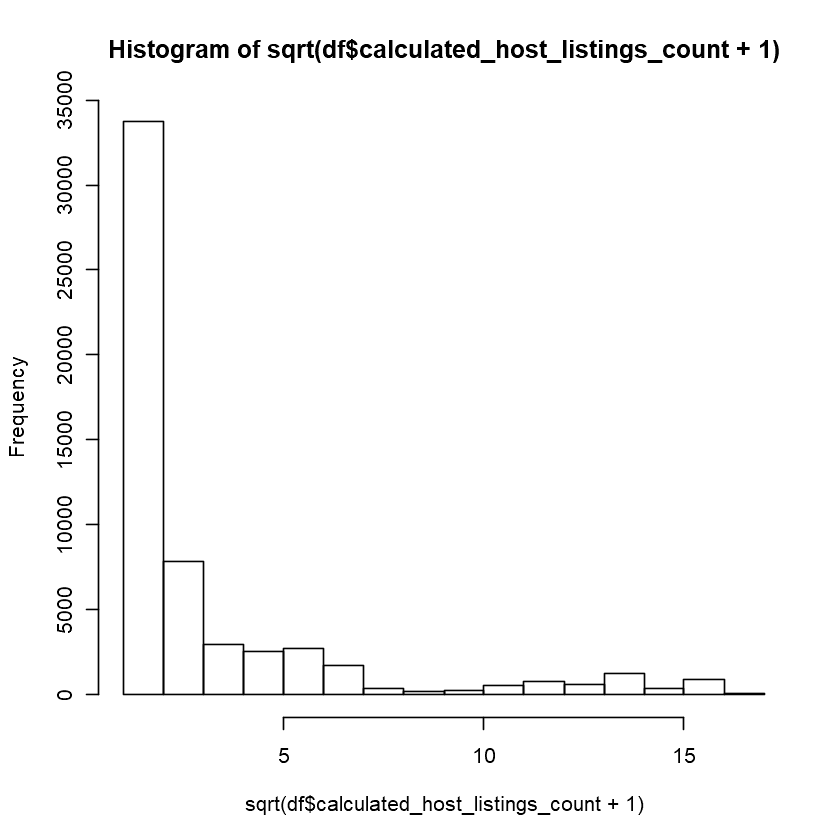

In [85]:
hist(df$calculated_host_listings_count)

hist(sqrt(df$calculated_host_listings_count + 1))

In [86]:
# convertin into factor
df$calculated_host_listings_count<-cut(df$calculated_host_listings_count, c(0,2, 5, 20, 50, 200, 300), 
          labels = c("Single", "upFive", "upTwenty", "upFifty", "upTwoHundred", "More"), 
          right = FALSE)

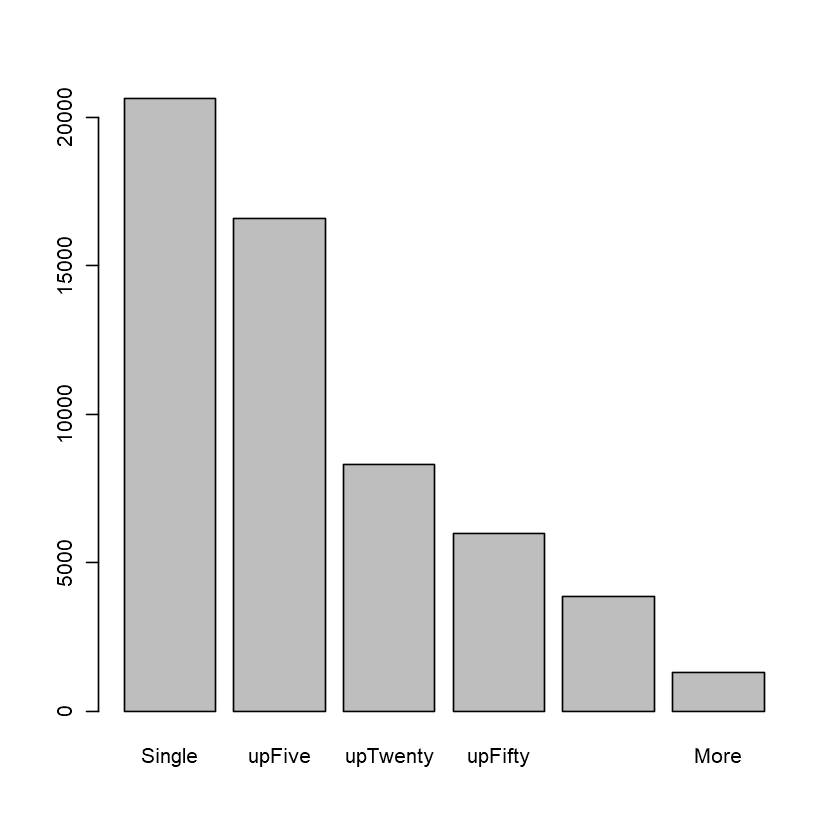

In [87]:
plot(df$calculated_host_listings_count)

## reviews_per_month

In [88]:
summary(df$reviews_per_month)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.01    0.56    1.54    2.17    3.21   29.56   11293 

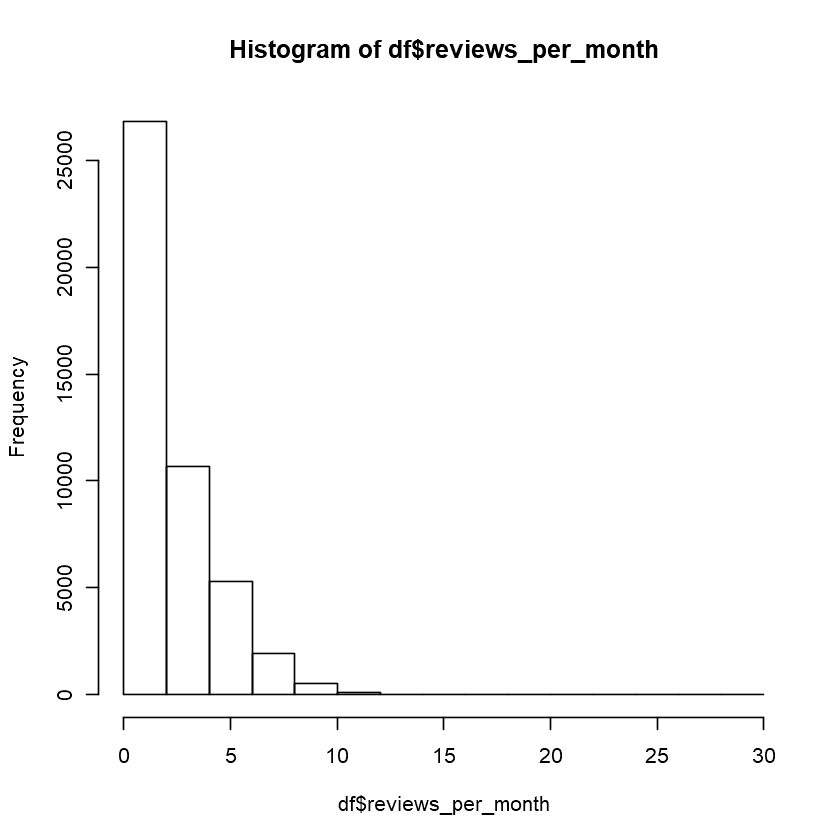

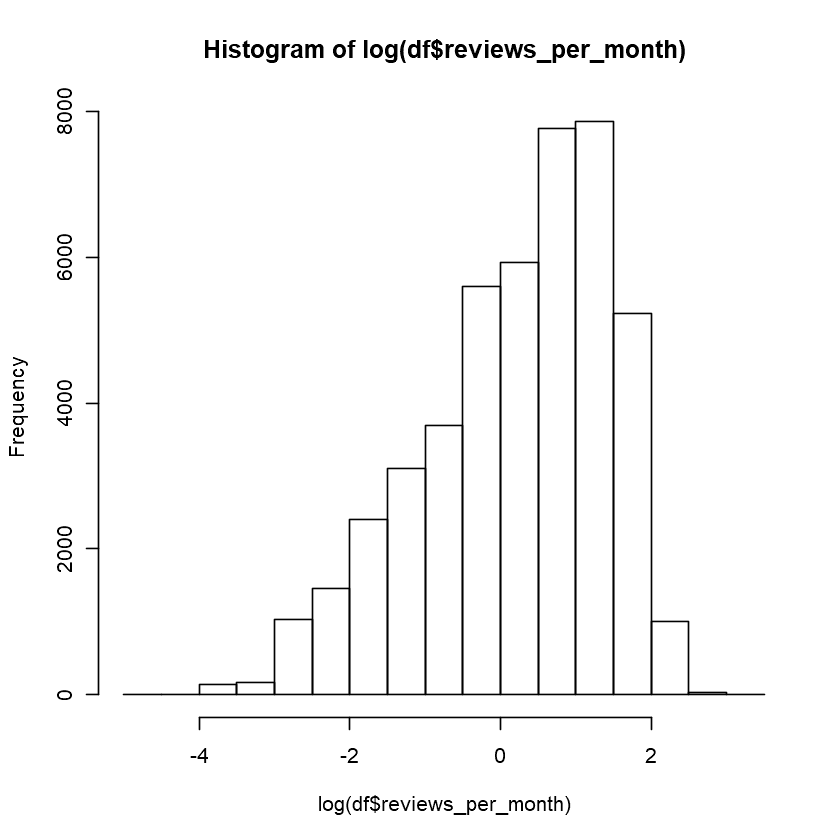

In [89]:
hist(df$reviews_per_month)

hist(log(df$reviews_per_month))

In [90]:
# replace missing values by 11
df$reviews_per_month[is.na(df$reviews_per_month)] <- 100
df$reviews_per_month<-cut(df$reviews_per_month, c(0:10,200), labels = c(1:10, "Missing"), right = FALSE)

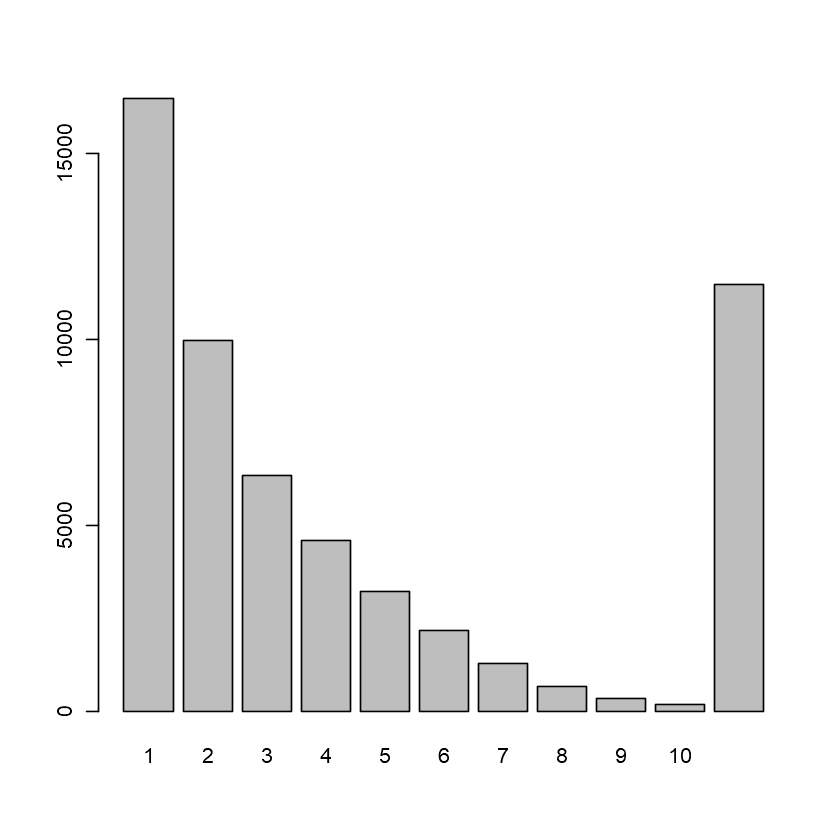

In [91]:
plot(df$reviews_per_month)

## host_seniority

In [92]:
summary(df$host_seniority)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   4.000   4.199   6.000 120.000 

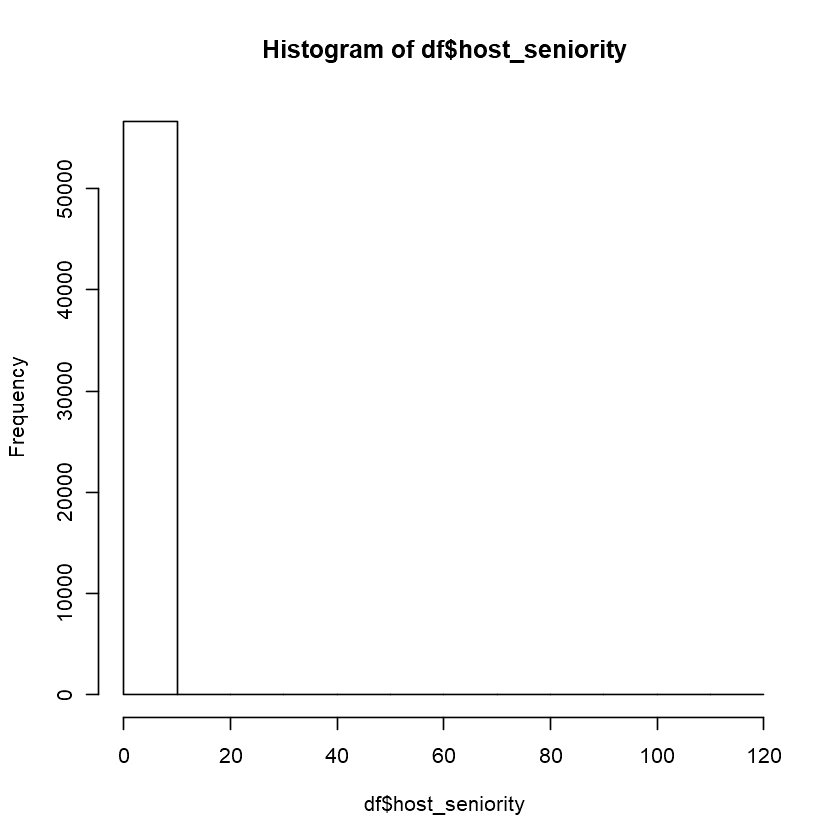

In [93]:
hist(df$host_seniority)

In [94]:
### removing values bigger than 20
df$host_seniority[df$host_seniority>20]<-NA

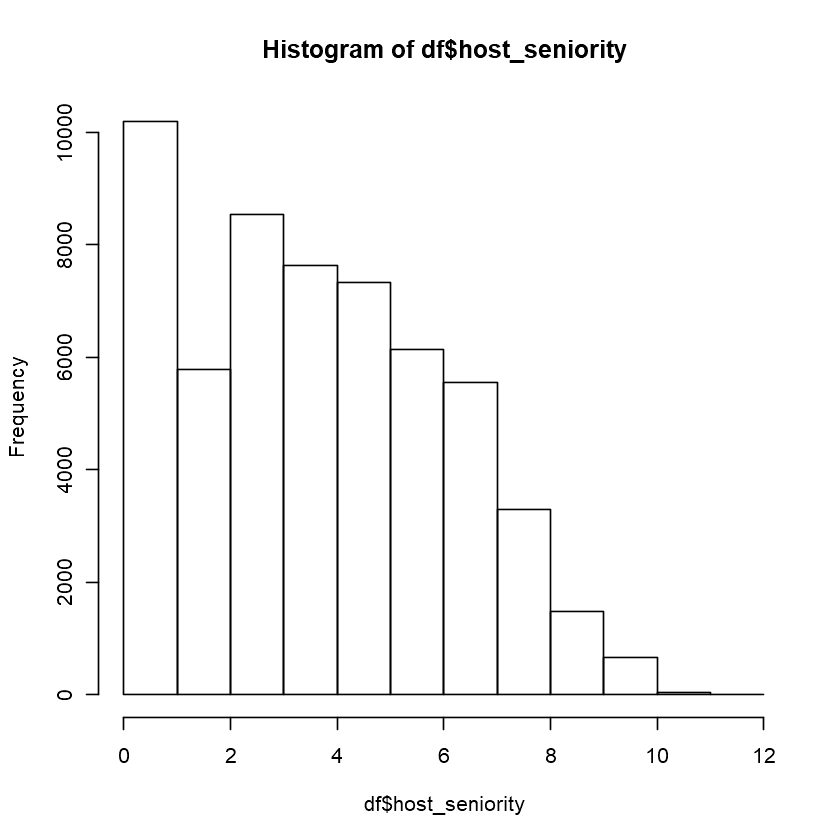

In [95]:
hist(df$host_seniority)

## Handle Missingness

[1] 56709    50

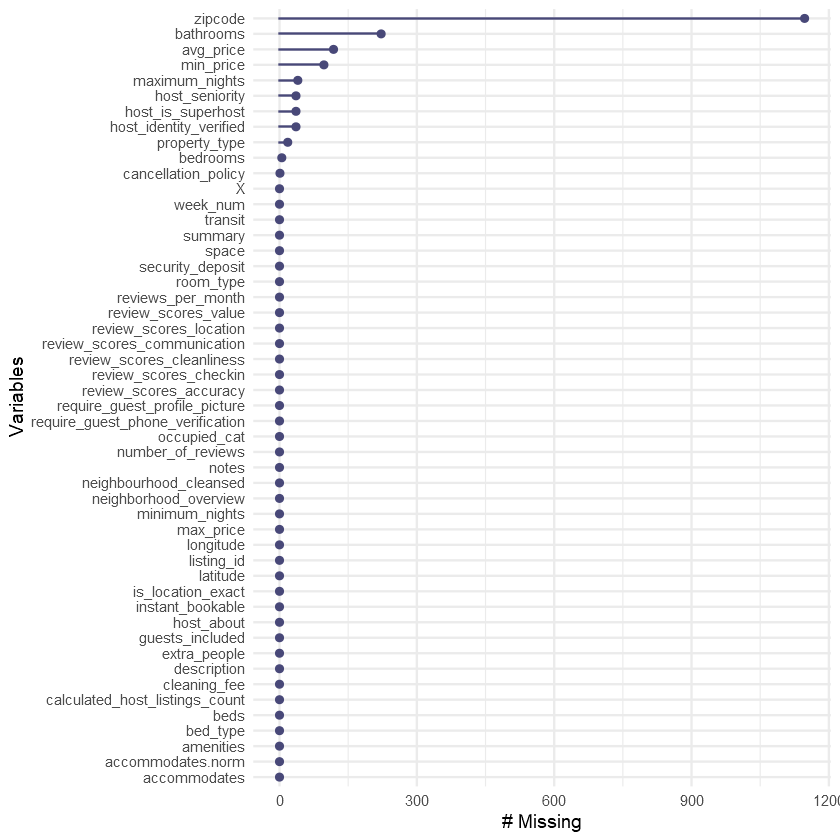

In [96]:
library(visdat)

dim(df)

gg_miss_var(df)

In [97]:
#add missing as another label
test<-addNA(df$zipcode, ifany = TRUE)

## Dataframe w/o missing value and outliers

In [98]:
mm <- mechkar::getMissingness(df,getRows=T)

dim(df)

df <- df[mm$rows,]

dim(df)

list(var = c(10, 17, 4, 5, 26, 7, 8, 40, 14, 18), na_count = c(1147, 222, 118, 97, 40, 36, 36, 36, 18, 5), rate = c(2, 0.4, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0, 0))This dataset has 55124 (97.2%) complete rows. Original data has 56709 rows.



[1] 56709    50

[1] 55124    50

In [99]:
#exploreData(df[no.factors], y = 'occupied_cat', dir="c:\\bb\\airbnb\\data\\after_cleanising")

In [100]:
con<-file(filename_clean,encoding="UTF-8")

write.csv(df,file=con, row.names = FALSE)

save(df, file=gsub(".csv", ".RData", filename_clean))